# Imports

In [ ]:
# imports
import numpy as np
import json, os, time, sys
from torch.utils.data import Dataset
import torch
import copy
import pandas as pd
from absl import app
from absl import flags
from zipfile import ZipFile

import torch
import sklearn
import scipy.linalg
%pip install iisignature
import iisignature as sig
import warnings

from typing import List
import torch.nn as nn
import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import socket
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from torch.backends import cudnn
import gc
import scipy.stats as stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp311-cp311-linux_x86_64.whl size=3246077 sha256=00bdd448538b79eb50200dcdc5ac27ddbfd0120e56f1b142fd66c6250eab5fff
  Stored in directory: /root/.cache/pip/wheels/1c/f4/57/0b4d3787a07f20a3cd1a91835d6247f55ef899345267bcd6df
Successfully built iisignature


# Data Creation

In [ ]:
# utility functions
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

def compute_loss(X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
                 weight=0.5, M_obs=None, which_loss="easy"):
    """
    compute the loss of the true conditional expectation, as in
    model.compute_loss
    """
    loss_fun = LOSS_FUN_DICT[which_loss]
    if M_obs is not None:
        M_obs = torch.from_numpy(M_obs)
    loss = loss_fun(
        X_obs=torch.from_numpy(X_obs),
        Y_obs=torch.from_numpy(Y_obs),
        Y_obs_bj=torch.from_numpy(Y_obs_bj),
        n_obs_ot=torch.from_numpy(n_obs_ot),
        batch_size=batch_size, eps=eps, weight=weight,
        M_obs=M_obs).detach().numpy()
    return loss

# synthetic datasets:
#   this is only a small collection of the available datasets.
#   more can be found in the git repo.
class StockModel:
    """
    mother class for all stock models defining the variables and methods shared
    amongst all of them, some need to be defined individually
    """

    def __init__(self, drift, volatility, S0, nb_paths, nb_steps,
                 maturity, sine_coeff, **kwargs):
        self.drift = drift
        self.volatility = volatility
        self.S0 = S0
        self.nb_paths = nb_paths
        self.nb_steps = nb_steps
        self.maturity = maturity
        self.dt = maturity / nb_steps
        self.dimensions = np.size(S0)
        if sine_coeff is None:
            self.periodic_coeff = lambda t: 1
        else:
            self.periodic_coeff = lambda t: (1 + np.sin(sine_coeff * t))
        self.loss = None
        self.path_t = None
        self.path_y = None
        self.path_var_y = None

        self.return_var_implemented = False
        self.loss_comp_for_pow2_implemented = False

    def generate_paths(self, **options):
        """
        generate random paths according to the model hyperparams
        :return: stock paths as np.array, dim: [nb_paths, data_dim, nb_steps]
        """
        raise ValueError("not implemented yet")

    def next_cond_exp(self, *args, **kwargs):
        """
        compute the next point of the conditional expectation starting from
        given point for given time_delta
        :return: cond. exp. at next time_point (= current_time + time_delta)
        """
        raise ValueError("not implemented yet")

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, store_and_use_stored=True,
                         start_time=None, which_loss="easy",
                         return_var=False,
                         **kwargs):
        """
        compute conditional expectation similar to computing the prediction in
        the model.NJODE.forward
        ATTENTION: Works correctly only for non-masked data!
        :param times: see model.NJODE.forward
        :param time_ptr: see model.NJODE.forward
        :param X: see model.NJODE.forward, as np.array
        :param obs_idx: see model.NJODE.forward, as np.array
        :param delta_t: see model.NJODE.forward, as np.array
        :param T: see model.NJODE.forward
        :param start_X: see model.NJODE.forward, as np.array
        :param n_obs_ot: see model.NJODE.forward, as np.array
        :param return_path: see model.NJODE.forward
        :param get_loss: see model.NJODE.forward
        :param weight: see model.NJODE.forward
        :param store_and_use_stored: bool, whether the loss, and cond exp path
            should be stored and reused when calling the function again
        :param start_time: None or float, if float, this is first time point
        :param return_var: bool, whether to return the variance additionally to
                the process; only if self.return_var_implemented is True
        :param kwargs: unused, to allow for additional unused inputs
        :return: float (loss), if wanted paths of t and y (np.arrays)
        """
        if return_var and not self.return_var_implemented:
            return_var = False

        if return_path and store_and_use_stored:
            res = [self.loss, self.path_t, self.path_y]
            if return_var:
                res.append(self.path_var_y)
            if get_loss:
                if self.path_t is not None and self.loss is not None:
                    return res
            else:
                if self.path_t is not None:
                    return res
        elif store_and_use_stored:
            if get_loss:
                if self.loss is not None:
                    return self.loss

        y = start_X
        if return_var:
            var_y = start_X*0
        batch_size = start_X.shape[0]
        current_time = 0.0
        if start_time:
            current_time = start_time

        loss = 0

        if return_path:
            if start_time:
                path_t = []
                path_y = []
                if return_var:
                    path_var_y = []
            else:
                path_t = [0.]
                path_y = [y]
                if return_var:
                    path_var_y = [var_y]

        for i, obs_time in enumerate(times):
            # the following is needed for the combined stock model datasets
            if obs_time > T + 1e-10*delta_t:
                break
            if obs_time <= current_time:
                continue
            # Calculate conditional expectation stepwise
            while current_time < (obs_time - 1e-10*delta_t):
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                y = self.next_cond_exp(y, delta_t_, current_time)
                if return_var:
                    var_y = self.next_cond_exp(
                        var_y, delta_t_, current_time, variance=True)
                current_time = current_time + delta_t_

                # Storing the conditional expectation
                if return_path:
                    path_t.append(current_time)
                    path_y.append(y)
                    if return_var:
                        path_var_y.append(var_y)

            # Reached an observation - set new interval
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]

            # Update h. Also updating loss, tau and last_X
            Y_bj = y
            temp = copy.deepcopy(y)
            temp[i_obs] = X_obs
            y = temp
            Y = y
            if return_var:
                temp_var = copy.deepcopy(var_y)
                temp_var[i_obs] = X_obs*0
                var_y = temp_var

            if get_loss:
                loss = loss + compute_loss(
                    X_obs=X_obs, Y_obs=Y[i_obs], Y_obs_bj=Y_bj[i_obs],
                    n_obs_ot=n_obs_ot[i_obs],
                    batch_size=batch_size, weight=weight, which_loss=which_loss)
            if return_path:
                path_t.append(obs_time)
                path_y.append(y)
                if return_var:
                    path_var_y.append(var_y)

        # after every observation has been processed, propagating until T
        while current_time < T - 1e-10 * delta_t:
            if current_time < T - delta_t:
                delta_t_ = delta_t
            else:
                delta_t_ = T - current_time
            y = self.next_cond_exp(y, delta_t_, current_time)
            if return_var:
                var_y = self.next_cond_exp(
                    var_y, delta_t_, current_time, variance=True)
            current_time = current_time + delta_t_

            # Storing the predictions.
            if return_path:
                path_t.append(current_time)
                path_y.append(y)
                if return_var:
                    path_var_y.append(var_y)

        if get_loss and store_and_use_stored:
            self.loss = loss
        if return_path and store_and_use_stored:
            self.path_t = np.array(path_t)
            self.path_y = np.array(path_y)
            if return_var:
                self.path_var_y = np.array(path_var_y)

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            res = [loss, np.array(path_t), np.array(path_y)]
            if return_var:
                res.append(np.array(path_var_y))
            return res
        else:
            return loss

    def get_optimal_loss(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, weight=0.5, M=None, mult=None,
                         store_and_use_stored=True, return_var=False,
                         which_loss="easy"):
        if mult is not None and mult > 1:
            bs, dim = start_X.shape
            _dim = round(dim / mult)
            X = X[:, :_dim]
            start_X = start_X[:, :_dim]
            if M is not None:
                M = M[:, :_dim]

        # depending on whether method can return the variance, the result has
        #   len 3 or 4
        res = self.compute_cond_exp(
            times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot,
            return_path=True, get_loss=True, weight=weight, M=M,
            store_and_use_stored=store_and_use_stored, return_var=return_var,
            which_loss=which_loss)
        loss = res[0]
        return loss

class BlackScholes(StockModel):
    """
    standard Black-Scholes model, see:
    https://en.wikipedia.org/wiki/Black–Scholes_model
    https://en.wikipedia.org/wiki/Geometric_Brownian_motion
    """

    def __init__(self, drift, volatility, nb_paths, nb_steps, S0,  # initialize relevant parameters
                 maturity, sine_coeff=None, **kwargs):
        super(BlackScholes, self).__init__(
            drift=drift, volatility=volatility, nb_paths=nb_paths,
            nb_steps=nb_steps, S0=S0, maturity=maturity,
            sine_coeff=sine_coeff
        )

    def next_cond_exp(self, y, delta_t, current_t):
        return y * np.exp(self.drift * self.periodic_coeff(current_t) * delta_t)

    def generate_paths(self, start_X=None):
        drift = lambda x, t: self.drift * self.periodic_coeff(t) * x
        diffusion = lambda x, t: self.volatility * x
        spot_paths = np.empty(
            (self.nb_paths, self.dimensions, self.nb_steps + 1))
        dt = self.dt
        if start_X is not None:
            spot_paths[:, :, 0] = start_X
        for i in range(self.nb_paths):
            if start_X is None:
                spot_paths[i, :, 0] = self.S0
            for k in range(1, self.nb_steps + 1):
                random_numbers = np.random.normal(0, 1, self.dimensions)
                dW = random_numbers * np.sqrt(dt)
                spot_paths[i, :, k] = (
                        spot_paths[i, :, k - 1]
                        + drift(spot_paths[i, :, k - 1], (k - 1) * dt) * dt
                        + diffusion(spot_paths[i, :, k - 1], (k) * dt) * dW)
        # stock_path dimension: [nb_paths, dimension, time_steps]
        return spot_paths, dt

class BM(StockModel):
    """
    Brownian Motion
    """

    def __init__(
        self, nb_paths, nb_steps, maturity, dimension, drift=0, **kwargs):
        super().__init__(
            drift=drift, volatility=None, nb_paths=nb_paths,
            nb_steps=nb_steps, S0=0., maturity=maturity,
            sine_coeff=None,)
        assert dimension == 1
        self.return_var_implemented = True

    def next_cond_exp(self, y, delta_t, current_t, variance=False):
        if variance:
            next_y = y + delta_t
        else:
            next_y = y + self.drift * delta_t
        return next_y

    def generate_paths(self, start_X=None):
        spot_paths = np.zeros(
            (self.nb_paths, 1, self.nb_steps + 1))
        if start_X is not None:
            spot_paths[:, :, 0] = start_X
        dt = self.dt

        random_numbers = np.random.normal(
            0, 1, (self.nb_paths, 1, self.nb_steps)) * np.sqrt(dt)
        W = np.cumsum(random_numbers, axis=2)

        spot_paths[:, 0, 1:] = spot_paths[:, :, 0] + W[:, 0, :] + self.drift * np.arange(
            1, self.nb_steps+1) * dt

        # stock_path dimension: [nb_paths, dimension, time_steps]
        return spot_paths, dt

class BMNoisyObs(BM):
    """
    A Brownian Motion with noisy observations
    """

    def __init__(self, nb_paths, nb_steps, maturity, obs_noise, dimension,
                 **kwargs):
        super().__init__(
            nb_paths=nb_paths, nb_steps=nb_steps, maturity=maturity,
            dimension=dimension,)
        assert dimension == 1, "dimension has to be set to 1 for this dataset"
        self.path_t = None
        self.loss = None
        self.noise_sig = obs_noise["scale"]

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, store_and_use_stored=True,
                         start_time=None, M=None, which_loss="easy",
                         **kwargs):
        """
        Compute conditional expectation
        :param times: np.array, of observation times
        :param time_ptr: list, start indices of X and obs_idx for a given
                observation time, first element is 0, this pointer tells how
                many (and which) of the observations of X along the batch-dim
                belong to the current time, and obs_idx then tells to which of
                the batch elements they belong. In particular, not each batch-
                element has to jump at the same time, and only those elements
                which jump at the current time should be updated with a jump
        :param X: np.array, data tensor
        :param obs_idx: list, index of the batch elements where jumps occur at
                current time
        :param delta_t: float, time step for Euler
        :param T: float, the final time
        :param start_X: np.array, the starting point of X
        :param n_obs_ot: np.array, the number of observations over the
                entire time interval for each element of the batch
        :param return_path: bool, whether to return the path of h
        :param get_loss: bool, whether to compute the loss, otherwise 0 returned
        :param until_T: bool, whether to continue until T (for eval) or only
                until last observation (for training)
        :param M: None or np.array, if not None: the mask for the data, same
                size as X, with 0 or 1 entries
        :return: float (loss), if wanted paths of t and y (np.arrays)
        """
        if return_path and store_and_use_stored:
            if get_loss:
                if self.path_t is not None and self.loss is not None:
                    return self.loss, self.path_t, self.path_y
            else:
                if self.path_t is not None:
                    return self.loss, self.path_t, self.path_y
        elif store_and_use_stored:
            if get_loss:
                if self.loss is not None:
                    return self.loss

        bs = start_X.shape[0]
        self.observations = [[] for x in range(bs)]
        self.observed_t_all = [[] for x in range(bs)]

        y = start_X
        batch_size = bs
        current_time = 0.0
        if start_time:
            current_time = start_time

        loss = 0

        if return_path:
            if start_time:
                path_t = []
                path_y = []
            else:
                path_t = [0.]
                path_y = [y]

        for i, obs_time in enumerate(times):
            # Calculate conditional expectation stepwise
            while current_time < (obs_time - 1e-10 * delta_t):
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                y = self.next_cond_exp(y, delta_t_, current_time)
                current_time = current_time + delta_t_

                # Storing the conditional expectation
                if return_path:
                    path_t.append(current_time)
                    path_y.append(y)

            # Reached an observation - set new interval
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]

            # Update h. Also updating loss, tau and last_X
            Y_bj = y
            temp = copy.copy(y)
            for j, jj in enumerate(i_obs):
                self.observations[jj].append(X_obs[j])
                self.observed_t_all[jj].append(obs_time)
                size = len(self.observed_t_all[jj])
                Sig = np.zeros((size, size))
                for k in range(size):
                    tmin = self.observed_t_all[jj][k]
                    Sig[k, k+1:] = tmin
                    Sig[k+1:, k] = tmin
                    Sig[k, k] = tmin + self.noise_sig**2
                sigvec = np.array(self.observed_t_all[jj])
                Sig_inv = np.linalg.inv(Sig)
                obs = np.array(self.observations[jj])
                mu = np.dot(np.dot(sigvec, Sig_inv), obs)
                temp[jj] = mu
            y = temp
            Y = y

            if get_loss:
                loss = loss + compute_loss(
                    X_obs=X_obs, Y_obs=Y[i_obs], Y_obs_bj=Y_bj[i_obs],
                    n_obs_ot=n_obs_ot[i_obs], batch_size=batch_size,
                    weight=weight, M_obs=None, which_loss=which_loss)
            if return_path:
                path_t.append(obs_time)
                path_y.append(y)

        # after every observation has been processed, propagating until T
        while current_time < T - 1e-10 * delta_t:
            if current_time < T - delta_t:
                delta_t_ = delta_t
            else:
                delta_t_ = T - current_time
            y = self.next_cond_exp(y, delta_t_)
            current_time = current_time + delta_t_

            # Storing the predictions.
            if return_path:
                path_t.append(current_time)
                path_y.append(y)

        if get_loss and store_and_use_stored:
            self.loss = loss
        if return_path and store_and_use_stored:
            self.path_t = np.array(path_t)
            self.path_y = np.array(path_y)

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            return loss, np.array(path_t), np.array(path_y)
        else:
            return loss

class BMFiltering(StockModel):
    """
    A Brownian Motion filtering example. The Signal process is a BM $X$ and the
    observation process is given by
        $ Y = \\alpha X + W, $
    where $W$ is also a BM independent of $X$ and $\\alpha \\in \\R$.
    $ Z = (Y, X) $, i.e. the first coordinate is $Y$ and is always observed.
    expectation for incomplete observations
    https://en.wikipedia.org/wiki/Multivariate_normal_distribution

    optionally, in the IO_version, Y is the input and X the output coordinate
    """

    def __init__(self, nb_paths, nb_steps, maturity, alpha, dimension,
                 IO_version=False, **kwargs):
        super().__init__(
            drift=None, volatility=None, nb_paths=nb_paths,
            nb_steps=nb_steps, S0=np.array([0,0]), maturity=maturity,
            sine_coeff=None
        )
        self.alpha = alpha
        assert dimension == 2, "dimension has to be set to 2 for this dataset"
        self.path_t = None
        self.loss = None
        self.IO_version = IO_version
        if self.IO_version:
            self.output_coords = [1]
        else:
            self.output_coords = [0, 1]

    def next_cond_exp(self, y, delta_t, current_t):
        return y

    def get_mu(self, jj, which_coord_obs):
        if self.IO_version:
            N = len(self.observed_t_all[jj])
            sig_11 = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    sig_11[i,j] = ((self.alpha**2+1) *
                                   self.observed_t_all[jj][min(i,j)])
            sig_21 = self.alpha * np.array(
                self.observed_t_all[jj]).reshape((1,-1))
            sig_22 = self.observed_t_all[jj][-1]
            sig_11_inv = np.linalg.inv(sig_11)
            mu = np.dot(sig_21, np.dot(
                sig_11_inv, np.array(self.observed_X0[jj])))
            return mu

        sig = np.diag(self.observed_t_all_inc[jj]*2)
        M0 = np.tri(N=len(self.observed_0[jj]), k=0)[
            np.array(self.observed_0[jj])==1]
        M1 = np.tri(N=len(self.observed_1[jj]), k=0)[
            np.array(self.observed_1[jj])==1]
        r1, c1 = M0.shape
        r2, c2 = M1.shape
        M = np.zeros((r1+r2, c1*2))
        M[:r1, :c1] = self.alpha*M0
        M[:r1, c1:c1*2] = M0
        M[r1:, :c1] = M1
        sig_bar_22_inv = np.linalg.inv(
            np.dot(np.dot(M, sig), np.transpose(M)))
        m = np.zeros((1,c1*2))
        m[0, :c1] = 1
        sig_bar_12 = np.dot(np.dot(m, sig), np.transpose(M))
        obs_arr = np.array(
            self.observed_X0[jj]+self.observed_X1[jj])
        mu = np.dot(np.dot(sig_bar_12, sig_bar_22_inv), obs_arr)
        return mu

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, store_and_use_stored=True,
                         start_time=None, M=None, which_loss="easy",
                         **kwargs):
        """
        Compute conditional expectation
        :param times: np.array, of observation times
        :param time_ptr: list, start indices of X and obs_idx for a given
                observation time, first element is 0, this pointer tells how
                many (and which) of the observations of X along the batch-dim
                belong to the current time, and obs_idx then tells to which of
                the batch elements they belong. In particular, not each batch-
                element has to jump at the same time, and only those elements
                which jump at the current time should be updated with a jump
        :param X: np.array, data tensor
        :param obs_idx: list, index of the batch elements where jumps occur at
                current time
        :param delta_t: float, time step for Euler
        :param T: float, the final time
        :param start_X: np.array, the starting point of X
        :param n_obs_ot: np.array, the number of observations over the
                entire time interval for each element of the batch
        :param return_path: bool, whether to return the path of h
        :param get_loss: bool, whether to compute the loss, otherwise 0 returned
        :param until_T: bool, whether to continue until T (for eval) or only
                until last observation (for training)
        :param M: None or np.array, if not None: the mask for the data, same
                size as X, with 0 or 1 entries
        :return: float (loss), if wanted paths of t and y (np.arrays)
        """
        if return_path and store_and_use_stored:
            if get_loss:
                if self.path_t is not None and self.loss is not None:
                    return self.loss, self.path_t, self.path_y
            else:
                if self.path_t is not None:
                    return self.loss, self.path_t, self.path_y
        elif store_and_use_stored:
            if get_loss:
                if self.loss is not None:
                    return self.loss

        # in case of the IO version
        if M is None:
            M = np.ones_like(X)

        bs = start_X.shape[0]
        self.observed_0 = [[] for x in range(bs)]
        self.observed_1 = [[] for x in range(bs)]
        self.observed_X0 = [[] for x in range(bs)]
        self.observed_X1 = [[] for x in range(bs)]
        self.observed_t_all = [[] for x in range(bs)]
        self.observed_t_all_inc = [[] for x in range(bs)]

        y = start_X
        batch_size = bs
        current_time = 0.0
        if start_time:
            current_time = start_time

        loss = 0

        if return_path:
            if start_time:
                path_t = []
                path_y = []
            else:
                path_t = [0.]
                path_y = [y]

        for i, obs_time in enumerate(times):
            # Calculate conditional expectation stepwise
            while current_time < (obs_time - 1e-10 * delta_t):
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                y = self.next_cond_exp(y, delta_t_, current_time)
                current_time = current_time + delta_t_

                # Storing the conditional expectation
                if return_path:
                    path_t.append(current_time)
                    path_y.append(y)

            # Reached an observation - set new interval
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]
            M_obs = M[start:end]

            # Update h. Also updating loss, tau and last_X
            Y_bj = y
            temp = copy.deepcopy(y)
            for j, jj in enumerate(i_obs):
                if M_obs[j, 0] == 1:
                    self.observed_X0[jj].append(X_obs[j, 0])
                    self.observed_0[jj].append(1)
                else:
                    self.observed_0[jj].append(0)
                if M_obs[j, 1] == 1 and not self.IO_version:
                    self.observed_X1[jj].append(X_obs[j, 1])
                    self.observed_1[jj].append(1)
                else:
                    self.observed_1[jj].append(0)
                assert M_obs[j, :].sum() > 0
                self.observed_t_all[jj].append(obs_time)
                last = [0.] + self.observed_t_all[jj]
                self.observed_t_all_inc[jj].append(obs_time - last[-2])

                if (M_obs[j, 0] == 1 and M_obs[j, 1] == 1
                        and not self.IO_version):
                    temp[jj, 0] = X_obs[j, 0]
                    temp[jj, 1] = X_obs[j, 1]
                else:
                    assert M_obs[j, 0] == 1
                    temp[jj, 0] = X_obs[j, 0]
                    temp[jj, 1] = self.get_mu(jj=jj, which_coord_obs=0)
            y = temp
            Y = y

            if get_loss:
                loss = loss + compute_loss(
                    X_obs=X_obs[:, self.output_coords],
                    Y_obs=Y[i_obs][:, self.output_coords],
                    Y_obs_bj=Y_bj[i_obs][:, self.output_coords],
                    n_obs_ot=n_obs_ot[i_obs], batch_size=batch_size,
                    weight=weight, M_obs=M_obs[:, self.output_coords],
                    which_loss=which_loss)
            if return_path:
                path_t.append(obs_time)
                path_y.append(y)

        # after every observation has been processed, propagating until T
        while current_time < T - 1e-10 * delta_t:
            if current_time < T - delta_t:
                delta_t_ = delta_t
            else:
                delta_t_ = T - current_time
            y = self.next_cond_exp(y, delta_t_)
            current_time = current_time + delta_t_

            # Storing the predictions.
            if return_path:
                path_t.append(current_time)
                path_y.append(y)

        if get_loss and store_and_use_stored:
            self.loss = loss
        if return_path and store_and_use_stored:
            self.path_t = np.array(path_t)
            self.path_y = np.array(path_y)[:, :, self.output_coords]

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            return (loss, np.array(path_t),
                    np.array(path_y)[:, :, self.output_coords])
        else:
            return loss

    def generate_paths(self):
        spot_paths = np.zeros(
            (self.nb_paths, 2, self.nb_steps + 1))
        dt = self.dt

        random_numbers = np.random.normal(
            0, 1, (self.nb_paths, 2, self.nb_steps)) * np.sqrt(dt)
        W = np.cumsum(random_numbers, axis=2)

        spot_paths[:, 0, 1:] = W[:, 0, :] * self.alpha + W[:, 1, :]
        spot_paths[:, 1, 1:] = W[:, 0, :]

        # stock_path dimension: [nb_paths, dimension, time_steps]
        return spot_paths, dt

class Combined(StockModel):
    def __init__(self, stock_model_names, hyperparam_dicts, **kwargs):
        self.stock_model_names = stock_model_names
        self.hyperparam_dicts = hyperparam_dicts

    def compute_cond_exp(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                         n_obs_ot, return_path=True, get_loss=False,
                         weight=0.5, which_loss="easy", **kwargs):
        # get first stockmodel
        stockmodel = DATASETS[self.stock_model_names[0]](
            **self.hyperparam_dicts[0])
        T = self.hyperparam_dicts[0]['maturity']
        loss, path_t, path_y = stockmodel.compute_cond_exp(
            times, time_ptr, X, obs_idx, delta_t,
            T, start_X,
            n_obs_ot, return_path=True, get_loss=get_loss,
            weight=weight, store_and_use_stored=False, which_loss=which_loss)
        for i in range(1, len(self.stock_model_names)):
            start_X = path_y[-1, :, :]
            start_time = path_t[-1]
            T += self.hyperparam_dicts[i]['maturity']
            stockmodel = DATASETS[self.stock_model_names[i]](
                **self.hyperparam_dicts[i])
            _loss, _path_t, _path_y = stockmodel.compute_cond_exp(
                times, time_ptr, X, obs_idx, delta_t,
                T, start_X,
                n_obs_ot, return_path=True, get_loss=get_loss,
                weight=weight, start_time=start_time,
                store_and_use_stored=False, which_loss=which_loss)
            loss += _loss
            path_t = np.concatenate([path_t, _path_t])
            path_y = np.concatenate([path_y, _path_y], axis=0)

        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            return loss, np.array(path_t), np.array(path_y)
        else:
            return loss


In [ ]:
# collection of synthetic data models (find more in the git repo)
DATASETS = {
    "BlackScholes": BlackScholes,
    "BM": BM,
    "BMNoisyObs": BMNoisyObs,
    "BMFiltering": BMFiltering,
    "combined": Combined,
}

# Data generation and handeling

In [ ]:
def create_dataset(
        stock_model_name="BlackScholes",
        hyperparam_dict=None,
        seed=0):
    """
    create a synthetic dataset using one of the stock-models
    :param stock_model_name: str, name of the stockmodel, see _STOCK_MODELS
    :param hyperparam_dict: dict, contains all needed parameters for the model
            it can also contain additional options for dataset generation:
                - masked    None, float or array of floats. if None: no mask is
                            used; if float: lambda of the poisson distribution;
                            if array of floats: gives the bernoulli probability
                            for each coordinate to be observed
                - obs_noise    dict, if given: add noise to the observations
                            the dict needs the following keys: 'distribution'
                            (defining the distribution of the noise), and keys
                            for the parameters of the distribution (depending on
                            the used distribution); supported distributions
                            {'normal'}. Be aware that the noise needs to be
                            centered for the model to be able to learn the
                            correct dynamics.

    :param seed: int, random seed for the generation of the dataset
    :return: stock_paths, observed_dates, nb_obs, hyperparam_dict, obs_noise
    """
    np.random.seed(seed=seed)
    hyperparam_dict['model_name'] = stock_model_name
    obs_perc = hyperparam_dict['obs_perc']
    masked = False
    masked_lambda = None
    mask_probs = None
    if ("masked" in hyperparam_dict
            and hyperparam_dict['masked'] not in [None, False]):
        masked = True
        if isinstance(hyperparam_dict['masked'], float):
            masked_lambda = hyperparam_dict['masked']
        elif isinstance(hyperparam_dict['masked'], (tuple, list)):
            mask_probs = hyperparam_dict['masked']
            assert len(mask_probs) == hyperparam_dict['dimension']
        else:
            raise ValueError("please provide a float (poisson lambda) "
                             "in hyperparam_dict['masked']")

    stockmodel = DATASETS[stock_model_name](**hyperparam_dict)
    # stock paths shape: [nb_paths, dim, time_steps]
    stock_paths, dt = stockmodel.generate_paths()
    size = stock_paths.shape
    observed_dates = np.random.random(size=(size[0], size[2]))
    observed_dates = (observed_dates < obs_perc)*1
    observed_dates[:, 0] = 1
    nb_obs = np.sum(observed_dates[:, 1:], axis=1)
    if masked:
        mask = np.zeros(shape=size)
        mask[:,:,0] = 1
        for i in range(size[0]):
            for j in range(1, size[2]):
                if observed_dates[i,j] == 1:
                    if masked_lambda is not None:
                        amount = min(1+np.random.poisson(masked_lambda),
                                     size[1])
                        observed = np.random.choice(
                            size[1], amount, replace=False)
                        mask[i, observed, j] = 1
                    elif mask_probs is not None:
                        for k in range(size[1]):
                            mask[i, k, j] = np.random.binomial(1, mask_probs[k])
        observed_dates = mask
    if "obs_noise" in hyperparam_dict:
        obs_noise_dict = hyperparam_dict["obs_noise"]
        if obs_noise_dict["distribution"] == "normal":
            obs_noise = np.random.normal(
                loc=obs_noise_dict["loc"],
                scale=obs_noise_dict["scale"],
                size=size)
            if 'noise_at_start' in obs_noise_dict and \
                    obs_noise_dict['noise_at_start']:
                pass
            else:
                obs_noise[:,:,0] = 0
        else:
            raise ValueError("obs_noise distribution {} not implemented".format(
                obs_noise_dict["distribution"]))
    else:
        obs_noise = None

    hyperparam_dict['dt'] = dt

    # stock_path dimension: [nb_paths, dimension, time_steps]
    return stock_paths, observed_dates, nb_obs, hyperparam_dict, obs_noise

def create_combined_dataset(
        stock_model_names=("BlackScholes", "BM"),
        hyperparam_dicts=(None, None),
        seed=0):
    """
    create a synthetic dataset using one of the stock-models
    :param stock_model_names: list of str, each str is a name of a stockmodel,
            see _STOCK_MODELS
    :param hyperparam_dicts: list of dict, each dict contains all needed
            parameters for the model
    :param seed: int, random seed for the generation of the dataset
    :return: stock_paths, observed_dates, nb_obs, metadata, None
    """

    assert len(stock_model_names) == len(hyperparam_dicts)
    np.random.seed(seed=seed)

    # start to create paths from first model
    maturity = hyperparam_dicts[0]['maturity']
    hyperparam_dicts[0]['model_name'] = stock_model_names[0]
    obs_perc = hyperparam_dicts[0]['obs_perc']
    stockmodel = DATASETS[stock_model_names[0]](**hyperparam_dicts[0])
    stock_paths, dt = stockmodel.generate_paths()
    last = stock_paths[:, :, -1]
    size = stock_paths.shape
    observed_dates = np.random.random(size=(size[0], size[2]))
    observed_dates = (observed_dates < obs_perc)*1
    observed_dates[:, 0] = 1

    # for every other model, add the paths created with this model starting at
    #   last point of previous model
    for i in range(1, len(stock_model_names)):
        dt_last = dt
        assert hyperparam_dicts[i]['dimension'] == \
               hyperparam_dicts[i-1]['dimension']
        assert hyperparam_dicts[i]['nb_paths'] == \
               hyperparam_dicts[i-1]['nb_paths']
        maturity += hyperparam_dicts[i]['maturity']
        hyperparam_dicts[i]['model_name'] = stock_model_names[i]
        stockmodel = DATASETS[stock_model_names[i]](**hyperparam_dicts[i])
        _stock_paths, dt = stockmodel.generate_paths(start_X=last)
        size = _stock_paths.shape
        obs_perc = hyperparam_dicts[i]['obs_perc']
        _observed_dates = np.random.random(size=(size[0], size[2]))
        _observed_dates = (_observed_dates < obs_perc)*1
        assert dt_last == dt
        last = _stock_paths[:, :, -1]
        stock_paths = np.concatenate(
            [stock_paths, _stock_paths[:, :, 1:]], axis=2)
        observed_dates = np.concatenate(
            [observed_dates, _observed_dates[:, 1:]], axis=1)
    nb_obs = np.sum(observed_dates[:, 1:], axis=1)

    metadata = {'dt': dt, 'maturity': maturity,
                'dimension': hyperparam_dicts[0]['dimension'],
                'nb_paths': hyperparam_dicts[0]['nb_paths'],
                'model_name': 'combined',
                'stock_model_names': stock_model_names,
                'hyperparam_dicts': hyperparam_dicts}

    return stock_paths, observed_dates, nb_obs, metadata, None


class IrregularDataset(Dataset):
    """
    class for iterating over a dataset
    """
    def __init__(self, dataset_collection, idx=None):
        stock_paths, observed_dates, nb_obs, hyperparam_dict, obs_noise = \
            dataset_collection
        if idx is None:
            idx = np.arange(hyperparam_dict['nb_paths'])
        self.metadata = hyperparam_dict
        self.stock_paths = stock_paths[idx]
        self.observed_dates = observed_dates[idx]
        self.nb_obs = nb_obs[idx]
        self.obs_noise = obs_noise

    def __len__(self):
        return len(self.nb_obs)

    def __getitem__(self, idx):
        if type(idx) == int:
            idx = [idx]
        if self.obs_noise is None:
            obs_noise = None
        else:
            obs_noise = self.obs_noise[idx]
        # stock_path dimension: [BATCH_SIZE, DIMENSION, TIME_STEPS]
        return {"idx": idx, "stock_path": self.stock_paths[idx],
                "observed_dates": self.observed_dates[idx],
                "nb_obs": self.nb_obs[idx], "dt": self.metadata['dt'],
                "obs_noise": obs_noise}

def _get_func(name):
    """
    transform a function given as str to a python function
    :param name: str, correspond to a function,
            supported: 'exp', 'power-x' (x the wanted power)
    :return: numpy fuction
    """
    if name in ['exp', 'exponential']:
        return np.exp
    if 'power-' in name:
        x = float(name.split('-')[1])
        def pow(input):
            return np.power(input, x)
        return pow
    else:
        try:
            return eval(name)
        except Exception:
            return None


def _get_X_with_func_appl(X, functions, axis):
    """
    apply a list of functions to the paths in X and append X by the outputs
    along the given axis
    :param X: np.array, with the data,
    :param functions: list of functions to be applied
    :param axis: int, the data_dimension (not batch and not time dim) along
            which the new paths are appended
    :return: np.array
    """
    Y = X
    for f in functions:
        Y = np.concatenate([Y, f(X)], axis=axis)
    return Y


def CustomCollateFnGen(func_names=None):
    """
    a function to get the costume collate function that can be used in
    torch.DataLoader with the wanted functions applied to the data as new
    dimensions
    -> the functions are applied on the fly to the dataset, and this additional
    data doesn't have to be saved

    :param func_names: list of str, with all function names, see _get_func
    :return: collate function, int (multiplication factor of dimension before
                and after applying the functions)
    """
    # get functions that should be applied to X, additionally to identity
    functions = []
    if func_names is not None:
        for func_name in func_names:
            f = _get_func(func_name)
            if f is not None:
                functions.append(f)
    mult = len(functions) + 1

    def custom_collate_fn(batch):
        dt = batch[0]['dt']
        stock_paths = np.concatenate([b['stock_path'] for b in batch], axis=0)
        observed_dates = np.concatenate([b['observed_dates'] for b in batch],
                                        axis=0)
        obs_noise = None
        if batch[0]["obs_noise"] is not None:
            obs_noise = np.concatenate([b['obs_noise'] for b in batch], axis=0)
        masked = False
        mask = None
        if len(observed_dates.shape) == 3:
            masked = True
            mask = observed_dates
            observed_dates = observed_dates.max(axis=1)
        nb_obs = torch.tensor(
            np.concatenate([b['nb_obs'] for b in batch], axis=0))

        # here axis=1, since we have elements of dim
        #    [batch_size, data_dimension] => add as new data_dimensions
        sp = stock_paths[:, :, 0]
        if obs_noise is not None:
            sp = stock_paths[:, :, 0] + obs_noise[:, :, 0]
        start_X = torch.tensor(
            _get_X_with_func_appl(sp, functions, axis=1),
            dtype=torch.float32)
        X = []
        if masked:
            M = []
            start_M = torch.tensor(mask[:,:,0], dtype=torch.float32).repeat(
                (1,mult))
        else:
            M = None
            start_M = None
        times = []
        time_ptr = [0]
        obs_idx = []
        current_time = 0.
        counter = 0
        for t in range(1, observed_dates.shape[-1]):
            current_time += dt
            if observed_dates[:, t].sum() > 0:
                times.append(current_time)
                for i in range(observed_dates.shape[0]):
                    if observed_dates[i, t] == 1:
                        counter += 1
                        # here axis=0, since only 1 dim (the data_dimension),
                        #    i.e. the batch-dim is cummulated outside together
                        #    with the time dimension
                        sp = stock_paths[i, :, t]
                        if obs_noise is not None:
                            sp = stock_paths[i, :, t] + obs_noise[i, :, t]
                        X.append(_get_X_with_func_appl(sp, functions, axis=0))
                        if masked:
                            M.append(np.tile(mask[i, :, t], reps=mult))
                        obs_idx.append(i)
                time_ptr.append(counter)
        # if obs_noise is not None:
        #     print("noisy observations used")

        assert len(obs_idx) == observed_dates[:, 1:].sum()
        if masked:
            M = torch.tensor(np.array(M), dtype=torch.float32)
        res = {'times': np.array(times), 'time_ptr': np.array(time_ptr),
               'obs_idx': torch.tensor(obs_idx, dtype=torch.long),
               'start_X': start_X, 'n_obs_ot': nb_obs,
               'X': torch.tensor(np.array(X), dtype=torch.float32),
               'true_paths': stock_paths, 'observed_dates': observed_dates,
               'true_mask': mask, 'obs_noise': obs_noise,
               'M': M, 'start_M': start_M}
        return res

    return custom_collate_fn, mult

In [ ]:
def create_dataset_Z(
        stock_model_name="BlackScholes",
        hyperparam_dict=None,
        seed=0):
    """
    Create a synthetic dataset generating process Z using a stock model.

    :param stock_model_name: str, name of the stock model, see _STOCK_MODELS
    :param hyperparam_dict: dict, contains all needed parameters for the model
            it can also contain additional options for dataset generation:
                - masked    None, float or array of floats. if None: no mask is
                            used; if float: lambda of the poisson distribution;
                            if array of floats: gives the bernoulli probability
                            for each coordinate to be observed
                - obs_noise    dict, if given: add noise to the observations
                            the dict needs the following keys: 'distribution'
                            (defining the distribution of the noise), and keys
                            for the parameters of the distribution (depending on
                            the used distribution); supported distributions
                            {'normal'}. Be aware that the noise needs to be
                            centered for the model to be able to learn the
                            correct dynamics.
    :param seed: int, random seed for the generation of the dataset
    :return: Z_flattened, observed_dates, nb_obs, hyperparam_dict, obs_noise
             - Z_flattened: array of shape [nb_paths, dim*dim, time_steps],
                            flattened version of Z_t = (X_t - X_{\tau(t)}) (X_t - X_{\tau(t)})^T
                            for t >= 1, Z_0 = 0, and \tau(t) is the last observed time before t
             - observed_dates: observation indicators, shape [nb_paths, time_steps]
                               if not masked, or [nb_paths, dim, time_steps] if masked
             - nb_obs: array of shape [nb_paths], number of observed time steps per path (excluding t=0)
             - hyperparam_dict: updated hyperparameter dictionary
             - obs_noise: noise array of shape [nb_paths, dim, time_steps] or None
    """
    np.random.seed(seed=seed)
    hyperparam_dict['model_name'] = stock_model_name
    obs_perc = hyperparam_dict['obs_perc']
    masked = False
    masked_lambda = None
    mask_probs = None
    if ("masked" in hyperparam_dict
            and hyperparam_dict['masked'] not in [None, False]):
        masked = True
        if isinstance(hyperparam_dict['masked'], float):
            masked_lambda = hyperparam_dict['masked']
        elif isinstance(hyperparam_dict['masked'], (tuple, list)):
            mask_probs = hyperparam_dict['masked']
            assert len(mask_probs) == hyperparam_dict['dimension']
        else:
            raise ValueError("please provide a float (poisson lambda) "
                             "in hyperparam_dict['masked']")

    stockmodel = DATASETS[stock_model_name](**hyperparam_dict)
    # stock paths shape: [nb_paths, dim, time_steps]
    stock_paths, dt = stockmodel.generate_paths()
    size = stock_paths.shape
    observed_dates = np.random.random(size=(size[0], size[2]))
    observed_dates = (observed_dates < obs_perc)*1
    observed_dates[:, 0] = 1
    nb_obs = np.sum(observed_dates[:, 1:], axis=1)
    if masked:
        mask = np.zeros(shape=size)
        mask[:,:,0] = 1
        for i in range(size[0]):
            for j in range(1, size[2]):
                if observed_dates[i,j] == 1:
                    if masked_lambda is not None:
                        amount = min(1+np.random.poisson(masked_lambda),
                                     size[1])
                        observed = np.random.choice(
                            size[1], amount, replace=False)
                        mask[i, observed, j] = 1
                    elif mask_probs is not None:
                        for k in range(size[1]):
                            mask[i, k, j] = np.random.binomial(1, mask_probs[k])
        observed_dates = mask
    if "obs_noise" in hyperparam_dict:
        obs_noise_dict = hyperparam_dict["obs_noise"]
        if obs_noise_dict["distribution"] == "normal":
            obs_noise = np.random.normal(
                loc=obs_noise_dict["loc"],
                scale=obs_noise_dict["scale"],
                size=size)
            if 'noise_at_start' in obs_noise_dict and \
                    obs_noise_dict['noise_at_start']:
                pass
            else:
                obs_noise[:,:,0] = 0
        else:
            raise ValueError("obs_noise distribution {} not implemented".format(
                obs_noise_dict["distribution"]))
    else:
        obs_noise = None

    hyperparam_dict['dt'] = dt

    return stock_paths**2, observed_dates, nb_obs, hyperparam_dict, obs_noise

# NJODE

# Loss function

In [ ]:
def compute_var_loss(X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, type=1):
    if dim_to is None:
        dim_to = Y_obs.shape[1]
    if compute_variance == "variance":
        Y_var_bj_v = Y_var_bj[:, :dim_to] ** 2
        Y_var_v = Y_var[:, :dim_to] ** 2
        true_var_bj = (X_obs - Y_obs_bj.detach()) ** 2
        true_var = (X_obs - Y_obs.detach()) ** 2
        M_obs_var = M_obs
        sum_dim = 1
    elif compute_variance == "covariance":
        d2 = Y_var.shape[1]
        d = int(np.sqrt(d2))
        Y_var_bj_v = Y_var_bj.view(-1, d, d)
        Y_var_bj_v = Y_var_bj_v[:, :dim_to, :dim_to]
        Y_var_bj_v = torch.matmul(Y_var_bj_v.transpose(1, 2), Y_var_bj_v)
        Y_var_v = Y_var.view(-1, d, d)
        Y_var_v = Y_var_v[:, :dim_to, :dim_to]
        Y_var_v = torch.matmul(Y_var_v.transpose(1, 2), Y_var_v)
        # the following is a row vector for each batch sample
        true_var_bj = (X_obs - Y_obs_bj.detach()).unsqueeze(1)
        true_var = (X_obs - Y_obs.detach()).unsqueeze(1)
        true_var_bj = torch.matmul(true_var_bj.transpose(1, 2), true_var_bj)
        true_var = torch.matmul(true_var.transpose(1, 2), true_var)
        M_obs_var = M_obs.unsqueeze(1)
        M_obs_var = torch.matmul(M_obs_var.transpose(1, 2), M_obs_var)
        sum_dim = (1, 2)
    else:
        raise ValueError("compute_variance must be either 'variance' or "
                         "'covariance'")
    if type == 1:
        inner_var = (2 * weight * torch.sqrt(
            torch.sum(M_obs_var * (true_var - Y_var_v)**2, dim=sum_dim) + eps) +
                     2 * (1 - weight) * torch.sqrt(
                    torch.sum(M_obs_var * (true_var_bj - Y_var_bj_v) ** 2,
                              dim=sum_dim) + eps)) ** 2
    elif type == 2:
        inner_var = 2 * weight * torch.sum(
            M_obs_var * (true_var - Y_var_v) ** 2, dim=sum_dim) + \
                    2 * (1 - weight) * torch.sum(
            M_obs_var * (true_var_bj - Y_var_bj_v) ** 2, dim=sum_dim)
    elif type == 3:
        inner_var = torch.sum(M_obs_var * (true_var_bj - Y_var_bj_v) ** 2,
                              dim=sum_dim)
    else:
        raise ValueError("type must be in {1, 2, 3}")

    outer = var_weight * torch.sum(inner_var / n_obs_ot)

    return outer

def compute_loss_2(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but using X_obs also in second part of loss
    instead of Y_obs -> should make the learning easier
    """
    if M_obs is None:
        M_obs = 1.

    inner = (2*weight * torch.sqrt(
        torch.sum(M_obs * (X_obs - Y_obs) ** 2, dim=1) + eps) +
             2*(1 - weight) * torch.sqrt(
                torch.sum(M_obs * (Y_obs_bj - X_obs) ** 2, dim=1)
                + eps)) ** 2
    outer = torch.sum(inner / n_obs_ot)

    # compute the variance loss term if wanted
    if compute_variance is not None:
        var_loss_type = 1
        if which_var_loss is not None:
            var_loss_type = which_var_loss
        outer += compute_var_loss(
            X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
            weight=weight, M_obs=M_obs,
            compute_variance=compute_variance, var_weight=var_weight,
            Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to, type=var_loss_type)

    return outer / batch_size

def compute_loss_3(
        X_obs_bj, X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but using X_obs also in second part of loss
    instead of Y_obs -> should make the learning easier
    """
    if M_obs is None:
        M_obs = 1.

    d2 = Y_obs_bj.shape[1]
    d = int(np.sqrt(d2))
    Y_obs_bj_mat = Y_obs_bj.view(-1, d, d)
    Y_obs_bj_mat1 = torch.matmul(Y_obs_bj_mat.transpose(1, 2),Y_obs_bj_mat)
    Y_obs_bj_mod = Y_obs_bj_mat1.view(-1, d2)

    #inner = torch.sum(M_obs * (Y_obs_bj_mod - X_obs) ** 2, dim=1)

    d2 = Y_obs.shape[1]
    d = int(np.sqrt(d2))
    Y_obs_mat = Y_obs_bj.view(-1, d, d)
    Y_obs_mat1 = torch.matmul(Y_obs_mat.transpose(1, 2),Y_obs_mat)
    Y_obs_mod = Y_obs_mat1.view(-1, d2)

    inner = (2*weight * torch.sqrt(
        torch.sum(M_obs * (Y_obs_bj_mod - X_obs_bj) ** 2, dim=1) + eps) +
             2*(1 - weight) * torch.sqrt(
                torch.sum(M_obs * (Y_obs_mod-X_obs) ** 2, dim=1)
                + eps)) ** 2

    outer = torch.sum(inner / n_obs_ot)

    return outer / batch_size

def compute_loss_IO(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but using X_obs also in second part of loss
    instead of Y_obs and squaring the two terms directly instead of squaring the
    sum of the two terms
    """
    if M_obs is None:
        M_obs = 1.

    inner = 2*weight * torch.sum(M_obs * (X_obs - Y_obs) ** 2, dim=1) +\
            2*(1-weight) * torch.sum(M_obs * (Y_obs_bj - X_obs) ** 2, dim=1)

    outer = torch.sum(inner / n_obs_ot)

    # compute the variance loss term if wanted
    if compute_variance is not None:
        var_loss_type = 2
        if which_var_loss is not None:
            var_loss_type = which_var_loss
        outer += compute_var_loss(
            X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
            weight=weight, M_obs=M_obs,
            compute_variance=compute_variance, var_weight=var_weight,
            Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to, type=var_loss_type)

    return outer / batch_size

def compute_loss_noisy_obs(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None,
        compute_variance=None, var_weight=1.,
        Y_var_bj=None, Y_var=None, dim_to=None, which_var_loss=None):
    """
    similar to compute_loss, but only using the 2nd term of the original loss
    function, which enables training with noisy observations
    """
    if M_obs is None:
        M_obs = 1.

    inner = torch.sum(M_obs * (Y_obs_bj - X_obs) ** 2, dim=1)

    outer = torch.sum(inner / n_obs_ot)

    # compute the variance loss term if wanted
    if compute_variance is not None:
        var_loss_type = 3
        if which_var_loss is not None:
            var_loss_type = which_var_loss
        outer += compute_var_loss(
            X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
            weight=weight, M_obs=M_obs,
            compute_variance=compute_variance, var_weight=var_weight,
            Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to, type=var_loss_type)

    return outer / batch_size

def compute_jump_loss(
        X_obs, Y_obs, Y_obs_bj, n_obs_ot, batch_size, eps=1e-10,
        weight=0.5, M_obs=None, compute_variance=None, **kwargs):
    """
    loss function with 1-norm instead of 2-norm for the two terms
    intuitively this should lead to the conditional median instead of mean (not
    proven)

    :param X_obs: torch.tensor, the true X values at the observations
    :param Y_obs: torch.tensor, the predicted values at the observation
    :param Y_obs_bj: torch.tensor, the predicted values before the jump at the
            observation
    :param n_obs_ot: torch.tensor, the number of observations over the entire
            time-line for each element of the batch
    :param batch_size: int or float
    :param eps: float, a small constant which is added before taking torch.sqrt
            s.t. the sqrt never becomes zero (which would yield NaNs for the
            gradient)
    :param weight: float in [0,1], weighting of the two parts of the loss
            function,
                0.5: standard loss as described in paper
                (0.5, 1): more weight to be correct after the jump, can be
                theoretically justified similar to standard loss
                1: only the value after the jump is trained
    :param M_obs: None or torch.tensor, if not None: same size as X_obs with
            0  and 1 entries, telling which coordinates were observed
    :param kwargs: additional arguments, not used; to be compatible with the
            other loss functions which allow for variance computations
    :return: torch.tensor (with the loss, reduced to 1 dim)
    """
    if M_obs is None:
        M_obs = 1.

    inner = torch.sum(M_obs * (X_obs - Y_obs) ** 2, dim=1)
    outer = torch.sum(inner / n_obs_ot)

    if compute_variance is not None:
        warnings.warn("compute_variance not implemented for the loss function "
                      "'compute_jump_loss'", UserWarning)

    return outer / batch_size

LOSS_FUN_DICT = {
    'easy': compute_loss_2,
    'IO': compute_loss_IO,
    'noisy_obs': compute_loss_noisy_obs,
    'jump': compute_jump_loss,
    'easy_vol': compute_loss_3,
}

In [ ]:
def init_weights(m, bias=0.0):  # initialize weights for model for linear NN
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(bias)

nonlinears = {  # dictionary of used non-linear activation functions. Reminder inputs
    'tanh': torch.nn.Tanh,
    'relu': torch.nn.ReLU,
    'prelu': torch.nn.PReLU,
}

def get_ffnn(input_size, output_size, nn_desc, dropout_rate, bias):
    """
    function to get a feed-forward neural network with the given description
    :param input_size: int, input dimension
    :param output_size: int, output dimension
    :param nn_desc: list of lists or None, each inner list defines one hidden
            layer and has 2 elements: 1. int, the hidden dim, 2. str, the
            activation function that should be applied (see dict nonlinears for
            possible options)
    :param dropout_rate: float,
    :param bias: bool, whether a bias is used in the layers
    :return: torch.nn.Sequential, the NN function
    """
    if nn_desc is not None and len(nn_desc) == 0:
        return torch.nn.Identity()
    if nn_desc is None:
        layers = [torch.nn.Linear(in_features=input_size, out_features=output_size, bias=bias)]  # take linear NN if
        # not specified otherwise
    else:
        layers = [torch.nn.Linear(in_features=input_size, out_features=nn_desc[0][0], bias=bias)]  # first linear
        # layer to specified dimension
        if len(nn_desc) > 1:
            for i in range(len(nn_desc) - 1):  # add multiple layers if multiple were given as input
                layers.append(nonlinears[nn_desc[i][1]]())  # add layer with specified activation function
                layers.append(torch.nn.Dropout(p=dropout_rate))  # add dropout layer
                layers.append(
                    torch.nn.Linear(nn_desc[i][0], nn_desc[i + 1][0],  # add linear layer between specified dimensions
                                    bias=bias))
        layers.append(nonlinears[nn_desc[-1][1]]())  # last specified activation function
        layers.append(torch.nn.Dropout(p=dropout_rate))  # add another dropout layer
        layers.append(torch.nn.Linear(in_features=nn_desc[-1][0], out_features=output_size, bias=bias))  # linear
        # output layer
    return torch.nn.Sequential(*layers)  # return the constructed NN

# NN

In [ ]:
class ODEFunc(torch.nn.Module):
    """
    implementing continuous update between observatios, f_{\theta} in paper
    """

    def __init__(self, input_size, hidden_size, ode_nn, dropout_rate=0.0,
                 bias=True, input_current_t=False, input_sig=False,
                 sig_depth=3, coord_wise_tau=False, input_scaling_func="tanh",
                 use_current_y_for_ode=False, input_var_t_helper=False):
        super().__init__()  # initialize class with given parameters
        self.input_current_t = input_current_t
        self.input_sig = input_sig
        self.sig_depth = sig_depth
        self.use_current_y_for_ode = use_current_y_for_ode
        self.input_var_t_helper = input_var_t_helper
        if input_scaling_func in ["id", "identity"]:
            self.sc_fun = torch.nn.Identity()
            print("neuralODE use input scaling with identity (no scaling)")
        else:
            self.sc_fun = torch.tanh
            print("neuralODE use input scaling with tanh")

        # create feed-forward NN, f(H,X,tau,t-tau)
        if coord_wise_tau:
            add = 2*input_size
        else:
            add = 2
        if input_current_t:
            if coord_wise_tau:
                add += input_size
            else:
                add += 1
        if input_var_t_helper:
            if coord_wise_tau:
                add += input_size
            else:
                add += 1
        if input_sig:
            add += sig_depth
        if use_current_y_for_ode:
            add += input_size
        self.f = get_ffnn(  # get a feedforward NN with the given specifications
            input_size=input_size + hidden_size + add, output_size=hidden_size,
            nn_desc=ode_nn, dropout_rate=dropout_rate, bias=bias
        )

    def forward(self, x, h, tau, tdiff, signature=None, current_y=None,
                delta_t=None):
        # dimension should be (batch, input_size) for x, (batch, hidden) for h,
        #    (batch, 1) for times

        input_f = torch.cat([self.sc_fun(x), self.sc_fun(h), tau, tdiff], dim=1)

        if self.input_current_t:
            input_f = torch.cat([input_f, tau+tdiff], dim=1)
        if self.input_var_t_helper:
            input_f = torch.cat([input_f, 1/torch.sqrt(tdiff+delta_t)], dim=1)
        if self.input_sig:
            input_f = torch.cat([input_f, signature], dim=1)
        if self.use_current_y_for_ode:
            input_f = torch.cat([input_f, self.sc_fun(current_y)], dim=1)

        df = self.f(input_f)
        return df

class FFNN(torch.nn.Module):
    """
    Implements feed-forward neural networks with tanh applied to inputs and the
    option to use a residual NN version
    """

    def __init__(self, input_size, output_size, nn_desc, dropout_rate=0.0,
                 bias=True, residual=False, masked=False, recurrent=False,
                 input_sig=False, sig_depth=3, clamp=None, input_t=False,
                 t_size=None, nb_outputs=None,
                 **kwargs):
        super().__init__()

        self.use_lstm = False
        if nn_desc is not None and isinstance(nn_desc[0][0], str) \
                and nn_desc[0][0].lower() == "lstm":
            self.use_lstm = True
            print("USE LSTM")
        in_size = input_size
        if masked:
            in_size = 2 * input_size
        if recurrent and not self.use_lstm:
            in_size += output_size
        if input_sig:
            in_size += sig_depth
        self.masked = masked
        self.recurrent = recurrent
        self.output_size = output_size
        self.nb_outputs = nb_outputs
        if self.nb_outputs is None:
            self.nb_outputs = 1
        self.input_sig = input_sig
        self.sig_depth = sig_depth
        self.input_t = input_t
        if self.input_t:
            in_size += t_size
        self.clamp = clamp
        self.lstm = None
        if self.use_lstm:
            self.lstm = torch.nn.LSTMCell(
                input_size=in_size, hidden_size=nn_desc[0][1], bias=bias)
            self.c_h = None
            in_size = nn_desc[0][1]*2
            assert in_size == output_size, \
                "when using an LSTM, the hidden_size has to be 2* " \
                "the LSTM output size"
            nn_desc = nn_desc[1:]
        self.ffnn = get_ffnn(
            input_size=in_size, output_size=self.output_size*self.nb_outputs,
            nn_desc=nn_desc, dropout_rate=dropout_rate, bias=bias)

        if residual:
            print('use residual network: input_size={}, output_size={}'.format(
                input_size, output_size))
            if input_size <= output_size:
                self.case = 1
            if input_size > output_size:
                self.case = 2
        else:
            self.case = 0

    def forward(self, nn_input, mask=None, sig=None, h=None, t=None):
        identity = None
        if self.case == 1:
            identity = torch.zeros((nn_input.shape[0], self.output_size)).to(
                self.device)
            identity[:, 0:nn_input.shape[1]] = nn_input
        elif self.case == 2:
            identity = nn_input[:, 0:self.output_size]

        if self.recurrent or self.use_lstm:
            assert h is not None
            # x = torch.tanh(nn_input)
            x = nn_input
        else:
            x = torch.tanh(nn_input)  # maybe not helpful
        if self.recurrent and not self.use_lstm:
            x = torch.cat((x, h), dim=1)
        if self.input_t:
            x = torch.cat((x, t), dim=1)
        if self.masked:
            assert mask is not None
            x = torch.cat((x, mask), dim=1)
        if self.input_sig:
            assert sig is not None
            x = torch.cat((x, sig), dim=1)
        if self.use_lstm:
            h_, c_ = torch.chunk(h, chunks=2, dim=1)
            h_, c_ = self.lstm(x.float(), (h_, c_))
            x = torch.concat((h_, c_), dim=1)
        out = self.ffnn(x.float())

        if self.nb_outputs > 1:
            out = out.reshape(-1, self.output_size, self.nb_outputs)
            if self.case > 0:
                identity = identity.reshape(-1, self.output_size, 1).repeat(
                    1, 1, self.nb_outputs)

        if self.case == 0:
            pass
        else:
            out = identity + out

        if self.clamp is not None:
            out = torch.clamp(out, min=-self.clamp, max=self.clamp)

        return out

    @property
    def device(self):
        device = next(self.parameters()).device
        return device

# model

In [ ]:
class NJODE(torch.nn.Module):
    """
    NJ-ODE model
    """
    def __init__(  # initialize the class by naming relevant features
            self, input_size, hidden_size, output_size,
            ode_nn, readout_nn, enc_nn, use_rnn,
            bias=True, dropout_rate=0, solver="euler",
            input_coords=None, output_coords=None,
            signature_coords=None, compute_variance=None, var_size=0,
            **options
    ):
        """
        init the model
        :param input_size: int
        :param hidden_size: int, size of latent variable process
        :param output_size: int
        :param ode_nn: list of list, defining the NN f, see get_ffnn
        :param readout_nn: list of list, defining the NN g, see get_ffnn
        :param enc_nn: list of list, defining the NN e, see get_ffnn
        :param use_rnn: bool, whether to use the RNN for 'jumps'
        :param bias: bool, whether to use a bias for the NNs
        :param dropout_rate: float
        :param solver: str, specifying the ODE solver, suppoorted: {'euler'}
        :param weight: float in [0.5, 1], the initial weight used in the loss
        :param weight_decay: float in [0,1], the decay applied to the weight of
                the loss function after each epoch, decaying towards 0.5
                    1: no decay, weight stays the same
                    0: immediate decay to 0.5 after 1st epoch
                    (0,1): exponential decay towards 0.5
        :param level: level for signature transform
        :param input_coords: list of int, the coordinates of the input
        :param output_coords: list of int, the coordinates of the output
        :param signature_coords: list of int, the coordinates of the signature
        :param compute_variance: None or one of {"variance", "covariance"},
                whether to compute the (marginal) variance or covariance matrix
        :param var_size: int, the size of the model variance estimate; this is
                already included in the output_size, but the variance
                coordinates are not included in the output_coords
        :param options: kwargs, used:
                - "classifier_nn"
                - "options" with arg a dict passed from train.train
                    used kwords: 'which_loss', 'residual_enc_dec',
                    'residual_enc', 'residual_dec',
                    'masked', 'input_current_t', 'input_sig', 'level',
                    'use_y_for_ode', 'enc_input_t', 'use_current_y_for_ode',
                    'use_observation_as_input', 'coord_wise_tau', 'clamp',
                    'ode_input_scaling_func', 'use_sig_for_classifier',
                    'classifier_loss_weight'
        """
        super().__init__()

        self.epoch = 1
        self.retrain_epoch = 0
        self.weight = 0.5
        self.use_rnn = use_rnn
        self.input_coords = input_coords
        self.output_coords = output_coords
        self.signature_coords = signature_coords
        self.compute_variance = compute_variance
        self.var_size = var_size
        self.var_weight = 1.
        self.which_var_loss = None

        # get options from the options of train input
        options1 = options['options']
        if 'which_loss' in options1:
            self.which_loss = options1['which_loss']
        else:
            self.which_loss = 'easy'
        assert self.which_loss in LOSS_FUN_DICT
        print('using loss: {}'.format(self.which_loss))
        if "var_weight" in options1:
            self.var_weight = options1['var_weight']
            print("using variance loss weight:", self.var_weight)
        if "which_var_loss" in options1:
            self.which_var_loss = options1['which_var_loss']
            print("using variance loss:", self.which_var_loss)

        self.residual_enc = True
        self.residual_dec = True
        if 'residual_enc_dec' in options1:
            residual_enc_dec = options1['residual_enc_dec']
            self.residual_enc = residual_enc_dec
            self.residual_dec = residual_enc_dec
        if 'residual_enc' in options1:
            self.residual_enc = options1['residual_enc']
        if 'residual_dec' in options1:
            self.residual_dec = options1['residual_dec']

        self.input_current_t = False
        if 'input_current_t' in options1:
            self.input_current_t = options1['input_current_t']
        self.input_var_t_helper = False
        if 'input_var_t_helper' in options1:
            self.input_var_t_helper = options1['input_var_t_helper']
        self.input_sig = False
        if 'input_sig' in options1:
            self.input_sig = options1['input_sig']
        self.level = 2
        if 'level' in options1:
            self.level = options1['level']
        self.sig_depth = sig.siglength(len(self.signature_coords)+1, self.level)
        self.masked = False
        if 'masked' in options1:
            self.masked = options1['masked']
        self.use_y_for_ode = False
        if 'use_y_for_ode' in options1:
            self.use_y_for_ode = options1['use_y_for_ode']
        self.use_current_y_for_ode = False
        if 'use_current_y_for_ode' in options1:
            self.use_current_y_for_ode = options1['use_current_y_for_ode']
        self.coord_wise_tau = False
        if 'coord_wise_tau' in options1 and self.masked:
            self.coord_wise_tau = options1['coord_wise_tau']
        self.enc_input_t = False
        if 'enc_input_t' in options1:
            self.enc_input_t = options1['enc_input_t']
        self.clamp = None
        if 'clamp' in options1:
            self.clamp = options1['clamp']
        self.ode_input_scaling_func = "tanh"
        if 'ode_input_scaling_func' in options1:
            self.ode_input_scaling_func = options1['ode_input_scaling_func']
        self.loss_weight = 1.
        t_size = 2
        if self.coord_wise_tau:
            t_size = 2*input_size
        use_observation_as_input = None
        if 'use_observation_as_input' in options1:
            use_observation_as_input = options1['use_observation_as_input']
        if use_observation_as_input is None:
            self.use_observation_as_input = lambda x: True
        elif isinstance(use_observation_as_input, bool):
            self.use_observation_as_input = \
                lambda x: use_observation_as_input
        elif isinstance(use_observation_as_input, float):
            self.use_observation_as_input = \
                lambda x: np.random.random() < use_observation_as_input
        elif isinstance(use_observation_as_input, str):
            self.use_observation_as_input = \
                eval(use_observation_as_input)
        val_use_observation_as_input = None
        if 'val_use_observation_as_input' in options1:
            val_use_observation_as_input = \
                options1['val_use_observation_as_input']
        if val_use_observation_as_input is None:
            self.val_use_observation_as_input = self.use_observation_as_input
        elif isinstance(val_use_observation_as_input, bool):
            self.val_use_observation_as_input = \
                lambda x: val_use_observation_as_input
        elif isinstance(val_use_observation_as_input, float):
            self.val_use_observation_as_input = \
                lambda x: np.random.random() < val_use_observation_as_input
        elif isinstance(val_use_observation_as_input, str):
            self.val_use_observation_as_input = \
                eval(val_use_observation_as_input)

        self.ode_f = ODEFunc(
            input_size=input_size, hidden_size=hidden_size, ode_nn=ode_nn,
            dropout_rate=dropout_rate, bias=bias,
            input_current_t=self.input_current_t, input_sig=self.input_sig,
            sig_depth=self.sig_depth, coord_wise_tau=self.coord_wise_tau,
            input_scaling_func=self.ode_input_scaling_func,
            use_current_y_for_ode=self.use_current_y_for_ode,
            input_var_t_helper=self.input_var_t_helper)
        self.encoder_map = FFNN(
            input_size=input_size, output_size=hidden_size, nn_desc=enc_nn,
            dropout_rate=dropout_rate, bias=bias, recurrent=self.use_rnn,
            masked=self.masked, residual=self.residual_enc,
            input_sig=self.input_sig, sig_depth=self.sig_depth,
            input_t=self.enc_input_t, t_size=t_size)
        self.readout_map = FFNN(
            input_size=hidden_size, output_size=output_size, nn_desc=readout_nn,
            dropout_rate=dropout_rate, bias=bias,
            residual=self.residual_dec, clamp=self.clamp,
            nb_outputs=None)

        self.solver = solver
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.apply(init_weights)

    @property
    def device(self):
        device = next(self.parameters()).device
        return device

    def ode_step(self, h, delta_t, current_time, last_X, tau, signature=None,
                 current_y=None):
        """Executes a single ODE step"""
        if not self.input_sig:
            signature = None
        if self.solver == "euler":
            h = h + delta_t * self.ode_f(
                x=last_X, h=h, tau=tau, tdiff=current_time - tau,
                signature=signature, current_y=current_y, delta_t=delta_t)
        else:
            raise ValueError("Unknown solver '{}'.".format(self.solver))

        current_time += delta_t
        return h, current_time

    def recreate_data(self, times, time_ptr, X, obs_idx, start_X):
        """
        recreates matrix of all observations
        first dim: which data path
        second dim: which time
        """
        # shape: [batch_size, time_steps+1, dimension]
        data = np.empty(shape=(start_X.shape[0], 1+len(times), start_X.shape[1]))
        data[:] = np.nan
        data[:,0,:] = start_X.detach().cpu().numpy()

        X = X.detach().cpu().numpy()
        for j, time in enumerate(times):
            start = time_ptr[j]
            end = time_ptr[j + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]
            data[i_obs, j+1, :] = X_obs
        times_new = np.concatenate(([0], times), axis=0)

        return times_new, data

    def get_signature(self, times, time_ptr, X, obs_idx, start_X):
        """
        Input: See forward
        Returns: signature of paths as nested list
        """
        # reconstructing the data, shape: [batch_size, time_steps+1, dim]
        times_new, data = self.recreate_data(
            times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
            start_X=start_X)

        # list of list of lists, shape: [batch_size, obs_dates[j], sig_length]
        signature = []
        for j in range(data.shape[0]):  # iterate over batch
            data_j = data[j, :, :]
            observed_j = []
            for i in range(data_j.shape[0]):
                # if the current batch-sample has an observation at the current
                #   time, add it to the list of observations
                if not np.all(np.isnan(data_j[i])):
                    observed_j += [i]
            data_j = data_j[observed_j, :]

            # replace no observations with last observation
            for i in range(1, data_j.shape[0]):
                # # OLD VERSION (SLOW)
                # for k in range(data_j.shape[1]):
                #     if np.isnan(data_j[i, k]):
                #         data_j[i, k] = data_j[i-1, k]
                ks = np.isnan(data_j[i, :])
                data_j[i, ks] = data_j[i-1, ks]

            times_j = times_new[observed_j].reshape(-1, 1)
            # add times to data for signature call
            path_j = np.concatenate((times_j, data_j), axis=1)
            # the following computes the signatures of all partial paths, from
            #   start to each point of the path
            signature.append(sig.sig(path_j, self.level, 2))

        return signature

    def forward(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                n_obs_ot, return_path=False, get_loss=True, until_T=False,
                M=None, start_M=None, which_loss=None, dim_to=None,
                predict_labels=None, return_classifier_out=False,
                return_at_last_obs=False, compute_variance_loss=True):
        """
        the forward run of this module class, used when calling the module
        instance without a method
        :param times: np.array, of observation times
        :param time_ptr: list, start indices of X and obs_idx for a given
                observation time, first element is 0, this pointer tells how
                many (and which) of the observations of X along the batch-dim
                belong to the current time, and obs_idx then tells to which of
                the batch elements they belong. In particular, not each batch-
                element has to jump at the same time, and only those elements
                which jump at the current time should be updated with a jump
        :param X: torch.tensor, data tensor
        :param obs_idx: list, index of the batch elements where jumps occur at
                current time
        :param delta_t: float, time step for Euler
        :param T: float, the final time
        :param start_X: torch.tensor, the starting point of X
        :param n_obs_ot: torch.tensor, the number of observations over the
                entire time interval for each element of the batch
        :param return_path: bool, whether to return the path of h
        :param get_loss: bool, whether to compute the loss, otherwise 0 returned
        :param until_T: bool, whether to continue until T (for eval) or only
                until last observation (for training)
        :param M: None or torch.tensor, if not None: the mask for the data, same
                size as X, with 0 or 1 entries
        :param start_M: None or torch.tensor, if not None: the mask for start_X,
                same size as start_X
        :param which_loss: see train.train, to overwrite which loss for eval
        :param dim_to: None or int, if given not all coordinates along the
                data-dimension axis are used but only up to dim_to. this can be
                used if func_appl_X is used in train, but the loss etc. should
                only be computed for the original coordinates (without those
                resulting from the function applications)
        :param predict_labels: None or torch.tensor with the true labels to
                predict
        :param return_classifier_out: bool, whether to return the output of the
                classifier
        :param return_at_last_obs: bool, whether to return the hidden state at
                the last observation time or at the final time
        :param epoch: int, the current epoch
        :param compute_variance_loss: bool, whether to compute the variance
                loss (in case self.compute_variance is not None). default: True

        :return: torch.tensor (hidden state at final time), torch.tensor (loss),
                    if wanted the paths of t (np.array) and h, y (torch.tensors)
        """
        if which_loss is None:
            which_loss = self.which_loss
        LOSS = LOSS_FUN_DICT[which_loss]

        last_X = start_X
        batch_size = start_X.size()[0]
        data_dim = start_X.size()[1]
        if dim_to is None:
            dim_to = len(self.output_coords)
        out_coords = self.output_coords[:dim_to]

        impute = False
        if (len(self.input_coords) == len(self.output_coords) and
                np.all(self.input_coords == self.output_coords)):
            impute = True
        if not impute and self.use_y_for_ode:
            raise ValueError(
                "use_y_for_ode can only be used when imputation is possible, "
                "i.e., when input and output coordinates are the same")


        if self.coord_wise_tau:
            tau = torch.tensor([[0.0]]).repeat(batch_size, self.input_size).to(
                self.device)
        else:
            tau = torch.tensor([[0.0]]).repeat(batch_size, 1).to(
                self.device)
        current_time = 0.0
        loss = torch.tensor(0.).to(self.device)
        c_sig = None

        if self.input_sig:
            if X.shape[0] == 0:  # if no data, set signature to 0
                pass
            elif self.masked:
                Mdc = M.clone()
                Mdc[Mdc==0] = np.nan
                X_obs_impute = X * Mdc
                signature = self.get_signature(
                    times=times, time_ptr=time_ptr,
                    X=X_obs_impute[:, self.signature_coords],
                    obs_idx=obs_idx, start_X=start_X[:, self.signature_coords])
            else:
                signature = self.get_signature(
                    times=times, time_ptr=time_ptr,
                    X=X[:, self.signature_coords],
                    obs_idx=obs_idx, start_X=start_X[:, self.signature_coords])

            # in beginning, no path was observed => set sig to 0
            current_sig = np.zeros((batch_size, self.sig_depth))
            current_sig_nb = np.zeros(batch_size).astype(int)
            c_sig = torch.from_numpy(current_sig).float().to(self.device)

        if self.masked:
            if start_M is None:
                start_M = torch.ones_like(start_X)
                start_M = start_M[:, self.input_coords]
        else:
            start_M = None

        h = self.encoder_map(
            start_X[:, self.input_coords], mask=start_M,
            sig=c_sig,
            h=torch.zeros((batch_size, self.hidden_size)).to(self.device),
            t=torch.cat((tau, current_time - tau), dim=1).to(self.device))

        if return_path:
            path_t = [0]
            path_h = [h]
            y = self.readout_map(h)
            if self.var_size > 0:
                path_y = [y[:, :-self.var_size]]
                path_var = [y[:, -self.var_size:]]
            else:
                path_y = [y]
                path_var = None
        h_at_last_obs = h.clone()
        sig_at_last_obs = c_sig

        assert len(times) + 1 == len(time_ptr)

        for i, obs_time in enumerate(times):
            # Propagation of the ODE until next observation
            while current_time < (obs_time - 1e-10 * delta_t):  # 0.0001 delta_t used for numerical consistency.
                if current_time < obs_time - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = obs_time - current_time
                if self.solver == 'euler':
                    h, current_time = self.ode_step(
                        h, delta_t_, current_time,
                        last_X=last_X[:, self.input_coords], tau=tau,
                        signature=c_sig, current_y=self.readout_map(h))
                    current_time_nb = int(round(current_time / delta_t))
                else:
                    raise NotImplementedError

                # Storing the predictions.
                if return_path:
                    path_t.append(current_time)
                    path_h.append(h)
                    y = self.readout_map(h)
                    if self.var_size > 0:
                        path_y.append(y[:, :-self.var_size])
                        path_var.append(y[:, -self.var_size:])
                    else:
                        path_y.append(y)

            # Reached an observation - only update those elements of the batch,
            #    for which an observation is made
            start = time_ptr[i]
            end = time_ptr[i + 1]
            X_obs = X[start:end]
            i_obs = obs_idx[start:end]
            if self.masked:
                if isinstance(M, np.ndarray):
                    M_obs = torch.from_numpy(M[start:end]).to(self.device)
                else:
                    M_obs = M[start:end]
                M_obs_in = M_obs[:, self.input_coords]
                M_obs_out = M_obs[:, out_coords]
                M_obs_sig = M_obs[:, self.signature_coords]
            else:
                M_obs = None
                M_obs_in = None
                M_obs_out = None
                M_obs_sig = None

            # decide whether to use observation as input
            if self.training:  # check whether model is in training or eval mode
                use_as_input = self.use_observation_as_input(self.epoch)
            else:
                use_as_input = self.val_use_observation_as_input(self.epoch)

            # update signature
            if self.input_sig:
                for ij, j in enumerate(i_obs):
                    # the signature is updated only if one of the sig-coords is
                    #   observed -> hence, it can happen that even though the
                    #   j-th batch sample is observed, the signature is not
                    #   updated because none of the sig-coords is observed
                    if M_obs_sig is None or M_obs_sig[ij].sum() > 0:
                        current_sig[j, :] = signature[j][current_sig_nb[j]]
                        current_sig_nb[j] += 1
                if use_as_input:
                    c_sig = torch.from_numpy(current_sig).float().to(
                        self.device)

            # Using RNNCell to update h. Also updating loss, tau and last_X
            Y_bj = self.readout_map(h)
            if use_as_input:
                X_obs_impute = X_obs
                temp = h.clone()
                if self.masked:
                    if impute:
                        # self imputation only possible if input and output are
                        #    the same and no quantile loss is used
                        X_obs_impute = X_obs * M_obs + (torch.ones_like(
                            M_obs.long()) - M_obs) * Y_bj[i_obs.long(), :data_dim]
                    else:
                        # otherwise set all masked entries to last value of X
                        X_obs_impute = X_obs * M_obs + (1-M_obs) * last_X
                c_sig_iobs = None
                if self.input_sig:
                    c_sig_iobs = c_sig[i_obs]
                temp[i_obs.long()] = self.encoder_map(
                    X_obs_impute[:, self.input_coords],
                    mask=M_obs_in, sig=c_sig_iobs, h=h[i_obs],
                    t=torch.cat((tau[i_obs], current_time - tau[i_obs]), dim=1))
                h = temp
                Y = self.readout_map(h)

                # update h and sig at last observation
                h_at_last_obs[i_obs.long()] = h[i_obs.long()].clone()
                sig_at_last_obs = c_sig
            else:
                Y = Y_bj

            if get_loss:
                Y_var_bj = None
                Y_var = None
                if self.var_size > 0:
                    Y_var_bj = Y_bj[i_obs.long(), -self.var_size:]
                    Y_var = Y[i_obs.long(), -self.var_size:]

                # INFO: X_obs has input and output coordinates, out_coords only
                #   has the output coordinates until dim_to; Y_obs has only the
                #   output coordinates (+ the var coords appended in the end),
                #   so taking them until dim_to (which is at max the size of the
                #   output_coords) corresponds to the out_coords
                if compute_variance_loss:
                    compute_variance = self.compute_variance
                else:
                    compute_variance = None
                if which_loss=='easy_vol':
                    unused_coords = [0]
                    loss = loss + LOSS(
                        X_obs_bj=X_obs[:,unused_coords ] , X_obs=X_obs[:, out_coords], Y_obs=Y[i_obs.long(), :dim_to],
                        Y_obs_bj=Y_bj[i_obs.long(), :dim_to],
                        n_obs_ot=n_obs_ot[i_obs.long()], batch_size=batch_size,
                        weight=self.weight, M_obs=M_obs_out,
                        compute_variance=compute_variance,
                        var_weight=self.var_weight,
                        Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to,
                        which_var_loss=self.which_var_loss)
                else:
                  loss = loss + LOSS(
                      X_obs=X_obs[:, out_coords], Y_obs=Y[i_obs.long(), :dim_to],
                      Y_obs_bj=Y_bj[i_obs.long(), :dim_to],
                      n_obs_ot=n_obs_ot[i_obs.long()], batch_size=batch_size,
                      weight=self.weight, M_obs=M_obs_out,
                      compute_variance=compute_variance,
                      var_weight=self.var_weight,
                      Y_var_bj=Y_var_bj, Y_var=Y_var, dim_to=dim_to,
                      which_var_loss=self.which_var_loss)

            # make update of last_X and tau, that is not inplace
            #    (otherwise problems in autograd)
            if use_as_input:
              temp_X = last_X.clone()
              temp_tau = tau.clone()
              if self.use_y_for_ode:
                  temp_X[i_obs.long()] = Y[i_obs.long(), :data_dim]
              else:
                  temp_X[i_obs.long()] = X_obs_impute
              if self.coord_wise_tau:
                  _M = torch.zeros_like(temp_tau)
                  _M[i_obs] = M_obs[:, self.input_coords]
                  temp_tau[_M==1] = obs_time.astype(np.float64)
              else:
                  temp_tau[i_obs.long()] = obs_time.astype(np.float64)
              last_X = temp_X
              tau = temp_tau

            if return_path:
                path_t.append(obs_time)
                path_h.append(h)
                if self.var_size > 0:
                    path_y.append(Y[:, :-self.var_size])
                    path_var.append(Y[:, -self.var_size:])
                else:
                    path_y.append(Y)

        # after every observation has been processed, propagating until T
        if until_T:
            while current_time < T - 1e-10 * delta_t:
                if current_time < T - delta_t:
                    delta_t_ = delta_t
                else:
                    delta_t_ = T - current_time
                if self.solver == 'euler':
                    h, current_time = self.ode_step(
                        h, delta_t_, current_time, last_X=last_X, tau=tau,
                        signature=c_sig, current_y=self.readout_map(h))
                else:
                    raise NotImplementedError

                # Storing the predictions.
                if return_path:
                    path_t.append(current_time)
                    path_h.append(h)
                    y = self.readout_map(h)
                    if self.var_size > 0:
                        path_y.append(y[:, :-self.var_size])
                        path_var.append(y[:, -self.var_size:])
                    else:
                        path_y.append(y)

        if return_at_last_obs:
            return h_at_last_obs, sig_at_last_obs
        if return_path:
            # path dimension: [time_steps, batch_size, output_size]
            var_path = None
            if self.var_size > 0:
                var_path = torch.stack(path_var)
            return h, loss, np.array(path_t), torch.stack(path_h), \
                   torch.stack(path_y)[:, :, :dim_to], var_path
        else:
            return h, loss

    def evaluate(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                 n_obs_ot, stockmodel, cond_exp_fun_kwargs=None,
                 diff_fun=lambda x, y: np.nanmean((x - y) ** 2),
                 return_paths=False, M=None, true_paths=None, start_M=None,
                 true_mask=None, mult=None, use_stored_cond_exp=False,):
        """
        evaluate the model at its current training state against the true
        conditional expectation
        :param times: see forward
        :param time_ptr: see forward
        :param X: see forward
        :param obs_idx: see forward
        :param delta_t: see forward
        :param T: see forward
        :param start_X: see forward
        :param n_obs_ot: see forward
        :param stockmodel: stock_model.StockModel instance, used to compute true
                cond. exp.
        :param cond_exp_fun_kwargs: dict, the kwargs for the cond. exp. function
                currently not used
        :param diff_fun: function, to compute difference between optimal and
                predicted cond. exp
        :param return_paths: bool, whether to return also the paths
        :param M: see forward
        :param start_M: see forward
        :param true_paths: np.array, shape [batch_size, dimension, time_steps+1]
        :param true_mask: as true_paths, with mask entries
        :param mult: None or int, if given not all coordinates along the
                data-dimension axis are used but only up to dim/mult. this can be
                used if func_appl_X is used in train, but the loss etc. should
                only be computed for the original coordinates (without those
                resulting from the function applications)
        :param use_stored_cond_exp: bool, whether to recompute the cond. exp.

        :return: eval-loss, if wanted paths t, y for true and pred
        """
        self.eval()

        dim = start_X.shape[1]
        dim_to = dim
        output_dim_to = len(self.output_coords)
        if mult is not None and mult > 1:
            dim_to = round(dim/mult)
            output_dim_to = round(len(self.output_coords)/mult)

        _, _, path_t, path_h, path_y, path_var = self.forward(
            times, time_ptr, X, obs_idx, delta_t, T, start_X, None,
            return_path=True, get_loss=False, until_T=True, M=M,
            start_M=start_M, dim_to=output_dim_to)

        if true_paths is None:
            if M is not None:
                M = M.detach().numpy()[:, :dim_to]
            if X.shape[0] > 0:  # if no data (eg. bc. obs_perc=0, not possible)
                X = X.detach().numpy()[:, :dim_to]
            _, true_path_t, true_path_y = stockmodel.compute_cond_exp(
                times, time_ptr, X,
                obs_idx.detach().numpy(),
                delta_t, T, start_X.detach().numpy()[:, :dim_to],
                n_obs_ot.detach().numpy(),
                return_path=True, get_loss=False, M=M,
                store_and_use_stored=use_stored_cond_exp)
        else:
            true_t = np.linspace(0, T, true_paths.shape[2])
            which_t_ind = []
            for t in path_t:
                which_t_ind.append(np.argmin(np.abs(true_t - t)))
            # INFO: first get the correct output coordinate, then the correct
            #   time index; afterwards transpose to [time, batch_size, dim]
            true_path_y = true_paths[:, self.output_coords[:output_dim_to], :][
                :, :, which_t_ind]
            true_path_y = np.transpose(true_path_y, axes=(2, 0, 1))
            true_path_t = true_t[which_t_ind]

        if path_y.detach().numpy().shape == true_path_y.shape:
            eval_metric = diff_fun(path_y.detach().numpy(), true_path_y)
        else:
            print(path_y.detach().numpy().shape)
            print(true_path_y.shape)
            raise ValueError("Shapes do not match!")
        if return_paths:
            return eval_metric, path_t, true_path_t, path_y, true_path_y
        else:
            return eval_metric

    def get_pred(self, times, time_ptr, X, obs_idx, delta_t, T, start_X,
                 n_obs_ot, M=None, start_M=None, which_loss=None):
        """
        get predicted path
        :return: dict, with prediction y and times t
        """
        self.eval()
        h, loss, path_t, path_h, path_y, path_var = self.forward(
            times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
            delta_t=delta_t, T=T, start_X=start_X, n_obs_ot=n_obs_ot,
            return_path=True, get_loss=True, until_T=True, M=M,
            start_M=start_M, which_loss=which_loss)
        return {'pred': path_y, 'pred_t': path_t, 'loss': loss,
                'pred_var': path_var}



# Training

In [ ]:
METR_COLUMNS: List[str] = [
    'epoch', 'train_time', 'val_time', 'train_loss', 'val_loss',
    'optimal_val_loss', 'test_loss', 'optimal_test_loss', 'evaluation_mean_diff']
default_nn = ((50, 'tanh'), (50, 'tanh'))

def train(
    model=None, seed=None,
    data_train=None, data_val=None, data_test=None,
    dataset_metadata=None, testset_metadata=None,
    epochs=100, batch_size=100, save_every=1,
    learning_rate=0.001,
    hidden_size=10, bias=True, dropout_rate=0.1,
    ode_nn=default_nn, readout_nn=default_nn,
    enc_nn=default_nn, use_rnn=False,
    solver="euler",
    **options
):


    """
    training function for NJODE model (models.NJODE),
    the model is automatically saved in the model-save-path with the given
    model id, also all evaluations of the model are saved there

    :param model: None or a NJODE model instance
    :param data_train: see data_utils
    :param data_val: see data_utils
    :param data_test: see data_utils
    :param dataset_metadata: see data_utils
    :param testset_metadata: see data_utils
    :param epochs: int, number of epochs to train, each epoch is one cycle
            through all (random) batches of the training data
    :param batch_size: int
    :param save_every: int, defined number of epochs after each of which the
            model is saved and plotted if wanted. whenever the model has a new
            best eval-loss it is also saved, independent of this number (but not
            plotted)
    :param learning_rate: float
    :param hidden_size: see models.NJODE
    :param bias: see models.NJODE
    :param dropout_rate: float
    :param ode_nn: see models.NJODE
    :param readout_nn: see models.NJODE
    :param enc_nn: see models.NJODE
    :param use_rnn: see models.NJODE
    :param solver: see models.NJODE
    :param saved_models_path: str, where to save the models
    :param options: kwargs, used keywords:
        'test_data_dict'    None, str or dict, if no None, this data_dict is
                        used to define the dataset for plot_only and
                        evaluation (if evaluate=True)
        'func_appl_X'   list of functions (as str, see data_utils)
                        to apply to X
        'masked'        bool, whether the data is masked (i.e. has
                        incomplete observations)
        'which_loss'    default: 'standard', see models.LOSS_FUN_DICT for
                        choices. suggested: 'easy' or 'very_easy'
        'residual_enc_dec'  bool, whether resNNs are used for encoder and
                        readout NN, used by models.NJODE. the provided value
                        is overwritten by 'residual_enc' & 'residual_dec' if
                        they are provided. default: False
        'residual_enc'  bool, whether resNNs are used for encoder NN,
                        used by models.NJODE.
                        default: True if use_rnn=False, else: False (this is
                        for backward compatibility)
        'residual_dec'  bool, whether resNNs are used for readout NN,
                        used by models.NJODE. default: True
        'use_y_for_ode' bool, whether to use y (after jump) or x_impute for
                        the ODE as input, only in masked case, default: True
        'use_current_y_for_ode' bool, whether to use the current y as input
                        to the ode. this should make the training more
                        stable in the case of long windows without
                        observations (cf. literature about stable output
                        feedback). default: False
        'coord_wise_tau'    bool, whether to use a coordinate wise tau
        'input_sig'     bool, whether to use the signature as input
        'level'         int, level of the signature that is used
        'input_current_t'   bool, whether to additionally input current time
                        to the ODE function f, default: False
        'enc_input_t'   bool, whether to use the time as input for the
                        encoder network. default: False
        'evaluate'      bool, whether to evaluate the model in the test set
                        (i.e. not only compute the val_loss, but also
                        compute the mean difference between the true and the
                        predicted paths comparing at each time point)
        'use_observation_as_input'  bool, whether to use the observations as
                        input to the model or whether to only use them for
                        the loss function (this can be used to make the
                        model learn to predict well far into the future).
                        can be a float in (0,1) to use an observation with
                        this probability as input. can also be a string
                        defining a function (when evaluated) that takes the
                        current epoch as input and returns a bool whether to
                        use the current observation as input (this can be a
                        random function, i.e. the output can depend on
                        sampling a random variable). default: true
        'val_use_observation_as_input'  bool, None, float or str, same as
                        'use_observation_as_input', but for the validation
                        set. default: None, i.e. same as for training set
        'ode_input_scaling_func'    None or str in {'id', 'tanh'}, the
                        function used to scale inputs to the neuralODE.
                        default: tanh
        'use_cond_exp'  bool, whether to use the conditional expectation
                        as reference for model evaluation, default: True
        'which_val_loss'   str, see models.LOSS_FUN_DICT for choices, which
                        loss to use for evaluation, default: 'easy'
        'input_coords'  list of int or None, which coordinates to use as
                        input. overwrites the setting from dataset_metadata.
                        if None, then all coordinates are used.
        'output_coords' list of int or None, which coordinates to use as
                        output. overwrites the setting from
                        dataset_metadata. if None, then all coordinates are
                        used.
        'signature_coords'  list of int or None, which coordinates to use as
                        signature coordinates. overwrites the setting from
                        dataset_metadata. if None, then all input
                        coordinates are used.
        'compute_variance'   None, bool or str, if None, then no variance
                        computation is done. if bool, then the (marginal)
                        variance is computed. if str "covariance", then the
                        covariance matrix is computed. ATTENTION: the model
                        output corresponds to the square root of the
                        variance (or the Cholesky decomposition of the
                        covariance matrix, respectivel), so if W is the
                        model's output corresponding to the variance, then
                        the models variance estimate is V=W^T*W or W^2,
                        depending whether the covariance or marginal
                        variance is estimated.
                        default: None
        'var_weight'    float, weight of the variance loss term in the loss
                        function, default: 1
        'input_var_t_helper'    bool, whether to use 1/sqrt(Delta_t) as
                        additional input to the ODE function f. this should help
                        to better learn the variance of the process.
                        default: False
        'which_var_loss'   None or int, which loss to use for the variance loss
                        term. default: None, which leads to using default choice
                        of the main loss function (which aligns with structure
                        of main loss function as far as reasonable). see
                        models.LOSS_FUN_DICT for choices (currently in {1,2,3}).

    :return: model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test
    """
    use_cond_exp = True
    masked = False
    if 'masked' in options:
        masked = options['masked']
    device = torch.device("cpu")

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # get input and output coordinates of the dataset
    input_coords = None
    output_coords = None
    signature_coords = None
    if "input_coords" in options:
        input_coords = options["input_coords"]
    elif "input_coords" in dataset_metadata:
        input_coords = dataset_metadata["input_coords"]
    if "output_coords" in options:
        output_coords = options["output_coords"]
    elif "output_coords" in dataset_metadata:
        output_coords = dataset_metadata["output_coords"]
    if "signature_coords" in options:
        signature_coords = options["signature_coords"]
    elif "signature_coords" in dataset_metadata:
        signature_coords = dataset_metadata["signature_coords"]
    if input_coords is None:
        input_size = dataset_metadata['dimension']
        input_coords = np.arange(input_size)
    else:
        input_size = len(input_coords)
    if output_coords is None:
        output_size = dataset_metadata['dimension']
        output_coords = np.arange(output_size)
    else:
        output_size = len(output_coords)
    if signature_coords is None:
        signature_coords = input_coords

    initial_print = '\ninput_coords: {}\noutput_coords: {}'.format(
        input_coords, output_coords)
    initial_print += '\ninput_size: {}\noutput_size: {}'.format(
        input_size, output_size)
    initial_print += '\nsignature_coords: {}'.format(signature_coords)
    dimension = dataset_metadata['dimension']
    T = dataset_metadata['maturity']
    delta_t = dataset_metadata['dt']
    original_output_dim = output_size
    original_input_dim = input_size

    # get functions to apply to the paths in X
    if 'func_appl_X' in options:  # list of functions to apply to the paths in X
        initial_print += '\napply functions to X'
        functions = options['func_appl_X']
        collate_fn, mult = CustomCollateFnGen(functions)
        input_size = input_size * mult
        output_size = output_size * mult
        input_coords = np.concatenate(
            [np.array(input_coords)+dimension*i for i in range(mult)])
        output_coords = np.concatenate(
            [np.array(output_coords)+dimension*i for i in range(mult)])
        initial_print += '\nnew input_coords: {}'.format(input_coords)
        initial_print += '\nnew output_coords: {}'.format(output_coords)
    else:
        functions = None
        collate_fn, mult = CustomCollateFnGen(None)
        mult = 1

    # get variance or covariance coordinates if wanted
    compute_variance = None
    var_size = 0
    if 'compute_variance' in options:
        if functions is not None:
            warnings.warn(
                "function application to X and concurrent variance/covariance "
                "computation might lead to problems! Use carefully!",
                UserWarning)
        compute_variance = options['compute_variance']
        if compute_variance == 'covariance':
            var_size = output_size**2
            initial_print += '\ncompute covariance of size {}'.format(var_size)
        elif compute_variance not in [None, False]:
            compute_variance = 'variance'
            var_size = output_size
            initial_print += '\ncompute (marginal) variance of size {}'.format(
                var_size)
        else:
            compute_variance = None
            initial_print += '\nno variance computation'
            var_size = 0
        # the models variance output is the Cholesky decomposition of the
        #   covariance matrix or the square root of the marginal variance.
        # for Y being the entire model output, the variance output is
        #   W=Y[:,-var_size:]
        output_size += var_size

    # get data-loader for training
    dl = DataLoader(  # class to iterate over training data
        dataset=data_train, collate_fn=collate_fn,
        shuffle=True, batch_size=batch_size, num_workers=1)
    dl_val = DataLoader(  # class to iterate over validation data
        dataset=data_val, collate_fn=collate_fn,
        shuffle=False, batch_size=len(data_val), num_workers=1)
    stockmodel = DATASETS[
        dataset_metadata['model_name']](**dataset_metadata)
    if data_test is not None:
        dl_test = DataLoader(  # class to iterate over test data
            dataset=data_test, collate_fn=collate_fn,
            shuffle=False, batch_size=len(data_test),
            num_workers=1)
        stockmodel_test = DATASETS[
            testset_metadata['model_name']](**testset_metadata)
    else:
        dl_test = dl_val
        stockmodel_test = stockmodel
        testset_metadata = dataset_metadata

    # validation loss function
    which_val_loss = 'easy'
    if 'which_loss' in options:
        which_val_loss = options['which_loss']
    if 'which_val_loss' in options:
        which_val_loss = options['which_val_loss']
    assert which_val_loss in LOSS_FUN_DICT

    if compute_variance is not None:
        warnings.warn(
            "optimal loss might be wrong, since the conditional "
            "variance is also learned, which is not accounted for in "
            "computation of the optimal loss",
            UserWarning)
    store_cond_exp = True
    if dl_val != dl_test:
        store_cond_exp = False
    if functions is not None and len(functions) > 0:
        initial_print += '\nWARNING: optimal loss computation for ' \
                          'power=2 not implemented for this model'
        corrected_string = "(corrected: only original X used) "
    else:
        corrected_string = ""
    opt_val_loss = compute_optimal_val_loss(
        dl_val, stockmodel, delta_t, T, mult=mult,
        store_cond_exp=store_cond_exp, return_var=False,
        which_loss=which_val_loss)
    initial_print += '\noptimal {}val-loss (achieved by true cond exp): ' \
                  '{:.5f}'.format(corrected_string, opt_val_loss)

    # get params_dict
    params_dict = {  # create a dictionary of the wanted parameters
        'input_size': input_size, 'epochs': epochs,
        'hidden_size': hidden_size, 'output_size': output_size, 'bias': bias,
        'ode_nn': ode_nn, 'readout_nn': readout_nn, 'enc_nn': enc_nn,
        'use_rnn': use_rnn,
        'dropout_rate': dropout_rate, 'batch_size': batch_size,
        'solver': solver,
        'learning_rate': learning_rate, 'test_size': test_size, 'seed': seed,
        'optimal_val_loss': opt_val_loss, 'options': options}

    # add additional values to params_dict (not to be shown in the description)
    params_dict['input_coords'] = input_coords
    params_dict['output_coords'] = output_coords
    params_dict['signature_coords'] = signature_coords
    params_dict['compute_variance'] = compute_variance
    params_dict['var_size'] = var_size

    # get the model & optimizer
    if model is None:
        model = NJODE(**params_dict)  # get NJODE model class from
        initial_print += '\ninitiate new model ...'
    model.to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=0.0005)
    best_val_loss = np.inf
    metr_columns = METR_COLUMNS

    # ---------------- TRAINING ----------------
    initial_print += '\n\nmodel overview:'
    print(initial_print)
    print(use_cond_exp)
    print(model, '\n')

    # compute number of parameters
    nr_params = 0
    for name, param in model.named_parameters():
        nr_params += param.nelement()  # count number of parameters
    print('# parameters={}\n'.format(nr_params))

    metric_app = []
    while model.epoch <= epochs:
        t = time.time()
        model.train()  # set model in train mode (e.g. BatchNorm)
        for i, b in tqdm.tqdm(enumerate(dl)):  # iterate over the dataloader
            optimizer.zero_grad()  # reset the gradient
            times = b["times"]
            time_ptr = b["time_ptr"]
            X = b["X"].to(device)
            M = b["M"]
            if M is not None:
                M = M.to(device)
            start_M = b["start_M"]
            if start_M is not None:
                start_M = start_M.to(device)
            start_X = b["start_X"].to(device)
            obs_idx = b["obs_idx"]
            n_obs_ot = b["n_obs_ot"].to(device)

            hT, loss = model(
                times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
                delta_t=delta_t, T=T, start_X=start_X, n_obs_ot=n_obs_ot,
                return_path=False, get_loss=True, M=M, start_M=start_M,)
            loss.backward()  # compute gradient of each weight regarding loss function
            optimizer.step()  # update weights with ADAM optimizer
        train_time = time.time() - t

        # -------- evaluation --------
        print("evaluating ...")
        t = time.time()
        batch = None
        with torch.no_grad():  # no gradient needed for evaluation
            loss_val = 0
            num_obs = 0
            eval_msd = 0
            model.eval()  # set model in evaluation mode
            for i, b in enumerate(dl_val):
                times = b["times"]
                time_ptr = b["time_ptr"]
                X = b["X"].to(device)
                M = b["M"]
                if M is not None:
                    M = M.to(device)
                start_M = b["start_M"]
                if start_M is not None:
                    start_M = start_M.to(device)
                start_X = b["start_X"].to(device)
                obs_idx = b["obs_idx"]
                n_obs_ot = b["n_obs_ot"].to(device)
                true_paths = b["true_paths"]
                true_mask = b["true_mask"]

                hT, c_loss = model(
                    times, time_ptr, X, obs_idx, delta_t, T, start_X,
                    n_obs_ot, return_path=False, get_loss=True, M=M,
                    start_M=start_M, which_loss=which_val_loss,)
                loss_val += c_loss.detach().numpy()
                num_obs += 1  # count number of observations

            # mean squared difference evaluation
            if 'evaluate' in options and options['evaluate']:
                eval_msd = evaluate_model(
                    model=model, dl_test=dl_test, device=device,
                    stockmodel_test=stockmodel_test,
                    testset_metadata=testset_metadata,
                    mult=mult, use_cond_exp=use_cond_exp,
                    eval_use_true_paths=False)

            val_time = time.time() - t
            loss_val = loss_val / num_obs
            eval_msd = eval_msd / num_obs
            train_loss = loss.detach().numpy()
            print_str = "epoch {}, weight={:.5f}, train-loss={:.5f}, " \
                        "optimal-val-loss={:.5f}, val-loss={:.5f}, ".format(
                model.epoch, model.weight, train_loss, opt_val_loss, loss_val)
            print(print_str)

        curr_metric = [model.epoch, train_time, val_time, train_loss,
                               loss_val, opt_val_loss, None, None]
        if 'evaluate' in options and options['evaluate']:
            curr_metric.append(eval_msd)
            print("evaluation mean square difference (test set): {:.5f}".format(
                eval_msd))
        else:
            curr_metric.append(None)
        metric_app.append(curr_metric)

        if loss_val < best_val_loss:
            print('save new best model: last-best-loss: {:.5f}, '
                  'new-best-loss: {:.5f}, epoch: {}'.format(
                best_val_loss, loss_val, model.epoch))
            best_val_loss = loss_val
        print("-"*100)

        model.epoch += 1

    df_metric = pd.DataFrame(data=metric_app, columns=metr_columns)

    return model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test


def compute_optimal_val_loss(
        dl_val, stockmodel, delta_t, T, mult=None,
        store_cond_exp=False, return_var=False, which_loss='easy'):
    """
    compute optimal evaluation loss (with the true cond. exp.) on the
    test-dataset
    :param dl_val: torch.DataLoader, used for the validation dataset
    :param stockmodel: stock_model.StockModel instance
    :param delta_t: float, the time_delta
    :param T: float, the terminal time
    :param mult: None or int, the factor by which the dimension is multiplied
    :param store_cond_exp: bool, whether to store the conditional expectation
    :return: float (optimal loss)
    """
    opt_loss = 0
    num_obs = 0
    for i, b in enumerate(dl_val):
        times = b["times"]
        time_ptr = b["time_ptr"]
        X = b["X"].detach().numpy()
        start_X = b["start_X"].detach().numpy()
        obs_idx = b["obs_idx"].detach().numpy()
        n_obs_ot = b["n_obs_ot"].detach().numpy()
        M = b["M"]
        if M is not None:
            M = M.detach().numpy()
        num_obs += 1
        opt_loss += stockmodel.get_optimal_loss(
            times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot, M=M,
            mult=mult, store_and_use_stored=store_cond_exp,
            return_var=return_var, which_loss=which_loss)
    return opt_loss / num_obs


def evaluate_model(
        model, dl_test, device, stockmodel_test, testset_metadata,
        mult, use_cond_exp, eval_use_true_paths):
    """
    evaluate the model on the test set

    Args:
        model:
        dl_test:
        device:
        stockmodel_test:
        testset_metadata:
        mult:
        use_cond_exp:
        eval_use_true_paths:

    Returns: evaluation metric

    """
    eval_msd = 0.
    for i, b in enumerate(dl_test):
        times = b["times"]
        time_ptr = b["time_ptr"]
        X = b["X"].to(device)
        M = b["M"]
        if M is not None:
            M = M.to(device)
        start_M = b["start_M"]
        if start_M is not None:
            start_M = start_M.to(device)
        start_X = b["start_X"].to(device)
        obs_idx = b["obs_idx"]
        n_obs_ot = b["n_obs_ot"].to(device)
        true_paths = b["true_paths"]
        true_mask = b["true_mask"]

        if use_cond_exp and not eval_use_true_paths:
            true_paths = None
            true_mask = None
        _eval_msd = model.evaluate(
            times=times, time_ptr=time_ptr, X=X,
            obs_idx=obs_idx,
            delta_t=testset_metadata["dt"],
            T=testset_metadata["maturity"],
            start_X=start_X, n_obs_ot=n_obs_ot,
            stockmodel=stockmodel_test, return_paths=False, M=M,
            start_M=start_M, true_paths=true_paths,
            true_mask=true_mask, mult=mult,
            use_stored_cond_exp=True, )
        eval_msd += _eval_msd

    return eval_msd

In [ ]:
METR_COLUMNS1: List[str] = [
    'epoch', 'train_time', 'val_time', 'train_loss', 'val_loss',]
default_nn = ((50, 'tanh'), (50, 'tanh'))

def train1(
    model=None, seed=None,
    data_train=None, data_val=None, data_test=None,
    dataset_metadata=None, testset_metadata=None,
    epochs=100, batch_size=100, save_every=1,
    learning_rate=0.001,
    hidden_size=10, bias=True, dropout_rate=0.1,
    ode_nn=default_nn, readout_nn=default_nn,
    enc_nn=default_nn, use_rnn=False,
    solver="euler",
    **options
):


    """
    training function for NJODE model (models.NJODE),
    the model is automatically saved in the model-save-path with the given
    model id, also all evaluations of the model are saved there

    :param model: None or a NJODE model instance
    :param data_train: see data_utils
    :param data_val: see data_utils
    :param data_test: see data_utils
    :param dataset_metadata: see data_utils
    :param testset_metadata: see data_utils
    :param epochs: int, number of epochs to train, each epoch is one cycle
            through all (random) batches of the training data
    :param batch_size: int
    :param save_every: int, defined number of epochs after each of which the
            model is saved and plotted if wanted. whenever the model has a new
            best eval-loss it is also saved, independent of this number (but not
            plotted)
    :param learning_rate: float
    :param hidden_size: see models.NJODE
    :param bias: see models.NJODE
    :param dropout_rate: float
    :param ode_nn: see models.NJODE
    :param readout_nn: see models.NJODE
    :param enc_nn: see models.NJODE
    :param use_rnn: see models.NJODE
    :param solver: see models.NJODE
    :param saved_models_path: str, where to save the models
    :param options: kwargs, used keywords:
        'test_data_dict'    None, str or dict, if no None, this data_dict is
                        used to define the dataset for plot_only and
                        evaluation (if evaluate=True)
        'func_appl_X'   list of functions (as str, see data_utils)
                        to apply to X
        'masked'        bool, whether the data is masked (i.e. has
                        incomplete observations)
        'which_loss'    default: 'standard', see models.LOSS_FUN_DICT for
                        choices. suggested: 'easy' or 'very_easy'
        'residual_enc_dec'  bool, whether resNNs are used for encoder and
                        readout NN, used by models.NJODE. the provided value
                        is overwritten by 'residual_enc' & 'residual_dec' if
                        they are provided. default: False
        'residual_enc'  bool, whether resNNs are used for encoder NN,
                        used by models.NJODE.
                        default: True if use_rnn=False, else: False (this is
                        for backward compatibility)
        'residual_dec'  bool, whether resNNs are used for readout NN,
                        used by models.NJODE. default: True
        'use_y_for_ode' bool, whether to use y (after jump) or x_impute for
                        the ODE as input, only in masked case, default: True
        'use_current_y_for_ode' bool, whether to use the current y as input
                        to the ode. this should make the training more
                        stable in the case of long windows without
                        observations (cf. literature about stable output
                        feedback). default: False
        'coord_wise_tau'    bool, whether to use a coordinate wise tau
        'input_sig'     bool, whether to use the signature as input
        'level'         int, level of the signature that is used
        'input_current_t'   bool, whether to additionally input current time
                        to the ODE function f, default: False
        'enc_input_t'   bool, whether to use the time as input for the
                        encoder network. default: False
        'evaluate'      bool, whether to evaluate the model in the test set
                        (i.e. not only compute the val_loss, but also
                        compute the mean difference between the true and the
                        predicted paths comparing at each time point)
        'use_observation_as_input'  bool, whether to use the observations as
                        input to the model or whether to only use them for
                        the loss function (this can be used to make the
                        model learn to predict well far into the future).
                        can be a float in (0,1) to use an observation with
                        this probability as input. can also be a string
                        defining a function (when evaluated) that takes the
                        current epoch as input and returns a bool whether to
                        use the current observation as input (this can be a
                        random function, i.e. the output can depend on
                        sampling a random variable). default: true
        'val_use_observation_as_input'  bool, None, float or str, same as
                        'use_observation_as_input', but for the validation
                        set. default: None, i.e. same as for training set
        'ode_input_scaling_func'    None or str in {'id', 'tanh'}, the
                        function used to scale inputs to the neuralODE.
                        default: tanh
        'use_cond_exp'  bool, whether to use the conditional expectation
                        as reference for model evaluation, default: True
        'which_val_loss'   str, see models.LOSS_FUN_DICT for choices, which
                        loss to use for evaluation, default: 'easy'
        'input_coords'  list of int or None, which coordinates to use as
                        input. overwrites the setting from dataset_metadata.
                        if None, then all coordinates are used.
        'output_coords' list of int or None, which coordinates to use as
                        output. overwrites the setting from
                        dataset_metadata. if None, then all coordinates are
                        used.
        'signature_coords'  list of int or None, which coordinates to use as
                        signature coordinates. overwrites the setting from
                        dataset_metadata. if None, then all input
                        coordinates are used.
        'compute_variance'   None, bool or str, if None, then no variance
                        computation is done. if bool, then the (marginal)
                        variance is computed. if str "covariance", then the
                        covariance matrix is computed. ATTENTION: the model
                        output corresponds to the square root of the
                        variance (or the Cholesky decomposition of the
                        covariance matrix, respectivel), so if W is the
                        model's output corresponding to the variance, then
                        the models variance estimate is V=W^T*W or W^2,
                        depending whether the covariance or marginal
                        variance is estimated.
                        default: None
        'var_weight'    float, weight of the variance loss term in the loss
                        function, default: 1
        'input_var_t_helper'    bool, whether to use 1/sqrt(Delta_t) as
                        additional input to the ODE function f. this should help
                        to better learn the variance of the process.
                        default: False
        'which_var_loss'   None or int, which loss to use for the variance loss
                        term. default: None, which leads to using default choice
                        of the main loss function (which aligns with structure
                        of main loss function as far as reasonable). see
                        models.LOSS_FUN_DICT for choices (currently in {1,2,3}).

    :return: model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test
    """
    use_cond_exp = False
    masked = False
    if 'masked' in options:
        masked = options['masked']
    device = torch.device("cpu")

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # get input and output coordinates of the dataset
    input_coords = None
    output_coords = None
    signature_coords = None
    if "input_coords" in options:
        input_coords = options["input_coords"]
    elif "input_coords" in dataset_metadata:
        input_coords = dataset_metadata["input_coords"]
    if "output_coords" in options:
        output_coords = options["output_coords"]
    elif "output_coords" in dataset_metadata:
        output_coords = dataset_metadata["output_coords"]
    if "signature_coords" in options:
        signature_coords = options["signature_coords"]
    elif "signature_coords" in dataset_metadata:
        signature_coords = dataset_metadata["signature_coords"]
    if input_coords is None:
        input_size = dataset_metadata['dimension']
        input_coords = np.arange(input_size)
    else:
        input_size = len(input_coords)
    if output_coords is None:
        output_size = dataset_metadata['dimension']
        output_coords = np.arange(output_size)
    else:
        output_size = len(output_coords)
    if signature_coords is None:
        signature_coords = input_coords

    initial_print = '\ninput_coords: {}\noutput_coords: {}'.format(
        input_coords, output_coords)
    initial_print += '\ninput_size: {}\noutput_size: {}'.format(
        input_size, output_size)
    initial_print += '\nsignature_coords: {}'.format(signature_coords)
    dimension = dataset_metadata['dimension']
    T = dataset_metadata['maturity']
    delta_t = dataset_metadata['dt']
    original_output_dim = output_size
    original_input_dim = input_size


    collate_fn, mult = CustomCollateFnGen(None)

    # get data-loader for training
    dl = DataLoader(  # class to iterate over training data
        dataset=data_train, collate_fn=collate_fn,
        shuffle=True, batch_size=batch_size, num_workers=1)
    dl_val = DataLoader(  # class to iterate over validation data
        dataset=data_val, collate_fn=collate_fn,
        shuffle=False, batch_size=len(data_val), num_workers=1)

    if data_test is not None:
        dl_test = DataLoader(  # class to iterate over test data
            dataset=data_test, collate_fn=collate_fn,
            shuffle=False, batch_size=len(data_test),
            num_workers=1)

    else:
        dl_test = dl_val
        testset_metadata = dataset_metadata

    # validation loss function
    which_val_loss = 'easy'
    if 'which_loss' in options:
        which_val_loss = options['which_loss']
    if 'which_val_loss' in options:
        which_val_loss = options['which_val_loss']
    assert which_val_loss in LOSS_FUN_DICT

    # get params_dict
    params_dict = {  # create a dictionary of the wanted parameters
        'input_size': input_size, 'epochs': epochs,
        'hidden_size': hidden_size, 'output_size': output_size, 'bias': bias,
        'ode_nn': ode_nn, 'readout_nn': readout_nn, 'enc_nn': enc_nn,
        'use_rnn': use_rnn,
        'dropout_rate': dropout_rate, 'batch_size': batch_size,
        'solver': solver,
        'learning_rate': learning_rate, 'seed': seed,
        'options': options}

    # add additional values to params_dict (not to be shown in the description)
    params_dict['input_coords'] = input_coords
    params_dict['output_coords'] = output_coords
    params_dict['signature_coords'] = signature_coords

    # get the model & optimizer
    if model is None:
        model = NJODE(**params_dict)  # get NJODE model class from
        initial_print += '\ninitiate new model ...'
    model.to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=0.0005)
    best_val_loss = np.inf
    metr_columns = METR_COLUMNS1

    # ---------------- TRAINING ----------------
    initial_print += '\n\nmodel overview:'
    print(initial_print)
    print(use_cond_exp)
    print(model, '\n')

    # compute number of parameters
    nr_params = 0
    for name, param in model.named_parameters():
        nr_params += param.nelement()  # count number of parameters
    print('# parameters={}\n'.format(nr_params))

    metric_app = []
    while model.epoch <= epochs:
        t = time.time()
        model.train()  # set model in train mode (e.g. BatchNorm)
        for i, b in tqdm.tqdm(enumerate(dl)):  # iterate over the dataloader
            optimizer.zero_grad()  # reset the gradient
            times = b["times"]
            time_ptr = b["time_ptr"]
            X = b["X"].to(device)
            M = b["M"]
            if M is not None:
                M = M.to(device)
            start_M = b["start_M"]
            if start_M is not None:
                start_M = start_M.to(device)
            start_X = b["start_X"].to(device)
            obs_idx = b["obs_idx"]
            n_obs_ot = b["n_obs_ot"].to(device)

            hT, loss = model(
                times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx,
                delta_t=delta_t, T=T, start_X=start_X, n_obs_ot=n_obs_ot,
                return_path=False, get_loss=True, M=M, start_M=start_M,)
            loss.backward()  # compute gradient of each weight regarding loss function
            optimizer.step()  # update weights with ADAM optimizer
        train_time = time.time() - t

        # -------- evaluation --------
        print("evaluating ...")
        t = time.time()
        batch = None
        with torch.no_grad():  # no gradient needed for evaluation
            loss_val = 0
            num_obs = 0
            eval_msd = 0
            model.eval()  # set model in evaluation mode
            for i, b in enumerate(dl_val):
                times = b["times"]
                time_ptr = b["time_ptr"]
                X = b["X"].to(device)
                M = b["M"]
                if M is not None:
                    M = M.to(device)
                start_M = b["start_M"]
                if start_M is not None:
                    start_M = start_M.to(device)
                start_X = b["start_X"].to(device)
                obs_idx = b["obs_idx"]
                n_obs_ot = b["n_obs_ot"].to(device)
                true_paths = b["true_paths"]
                true_mask = b["true_mask"]

                hT, c_loss = model(
                    times, time_ptr, X, obs_idx, delta_t, T, start_X,
                    n_obs_ot, return_path=False, get_loss=True, M=M,
                    start_M=start_M, which_loss=which_val_loss,)
                loss_val += c_loss.detach().numpy()
                num_obs += 1  # count number of observations

            val_time = time.time() - t
            loss_val = loss_val / num_obs
            eval_msd = eval_msd / num_obs
            train_loss = loss.detach().numpy()
            print_str = "epoch {}, weight={:.5f}, train-loss={:.5f}, " \
                        " val-loss={:.5f}, ".format(
                model.epoch, model.weight, train_loss, loss_val)
            print(print_str)

        curr_metric = [model.epoch, train_time, val_time, train_loss,
                               loss_val ]

        metric_app.append(curr_metric)

        if loss_val < best_val_loss:
            print('save new best model: last-best-loss: {:.5f}, '
                  'new-best-loss: {:.5f}, epoch: {}'.format(
                best_val_loss, loss_val, model.epoch))
            best_val_loss = loss_val
        print("-"*100)

        model.epoch += 1

    df_metric = pd.DataFrame(data=metric_app, columns=metr_columns)

    return model, df_metric, dl, dl_val, dl_test


# plot

In [ ]:
def plot_one_path_with_pred(
        device, model, batch, stockmodel, delta_t, T,
        path_to_plot=(0,),
        plot_variance=False, plot_true_var=True,
        functions=None, std_factor=1,
        model_name="NJODE", ylabels=None,
        legendlabels=None,
        use_cond_exp=True, same_yaxis=False,
        plot_obs_prob=False,
        reuse_cond_exp=True, output_coords=None,
        loss_quantiles=None, input_coords=None,
        which_loss='easy',
):
    """
    plot one path of the stockmodel together with optimal cond. exp. and its
    prediction by the model
    :param device: torch.device, to use for computations
    :param model: models.NJODE instance
    :param batch: the batch from where to take the paths
    :param stockmodel: stock_model.StockModel instance, used to compute true
            cond. exp.
    :param delta_t: float
    :param T: float
    :param path_to_plot: list of ints, which paths to plot (i.e. which elements
            oof the batch)
    :param plot_variance: bool, whether to plot the variance, if supported by
            functions (i.e. square has to be applied)
    :param functions: list of functions (as str), the functions applied to X
    :param std_factor: float, the factor by which std is multiplied
    :param model_name: str or None, name used for model in plots
    :param ylabels: None or list of str of same length as dimension of X
    :param legendlabels: None or list of str of length 4 or 5 (labels of
        i) true path, ii) our model, iii) true cond. exp., iv) observed values,
        v) true values at observation times (only if noisy observations are
        used))
    :param use_cond_exp: bool, whether to plot the conditional expectation
    :param same_yaxis: bool, whether to plot all coordinates with same range on
        y-axis
    :param plot_obs_prob: bool, whether to plot the probability of an
        observation for all times
    :param reuse_cond_exp: bool, whether to reuse the conditional expectation
        from the last computation
    :param output_coords: None or list of ints, the coordinates corresponding to
        the model output
    :param loss_quantiles: None or list of floats, the quantiles to plot for the
        loss
    :param input_coords: None or list of ints, the coordinates corresponding to
        the model input
    :param which_loss: str, the loss function to use for the computation

    :return: optimal loss
    """
    if model_name is None or model_name == "NJODE":
        model_name = 'our model'
    if device is None:
        device = model.device

    prop_cycle = plt.rcParams['axes.prop_cycle']  # change style of plot?
    colors = prop_cycle.by_key()['color']
    std_color = list(matplotlib.colors.to_rgb(colors[1])) + [0.5]
    std_color2 = list(matplotlib.colors.to_rgb(colors[2])) + [0.5]

    times = batch["times"]
    time_ptr = batch["time_ptr"]
    X = batch["X"].to(device)
    M = batch["M"]
    if M is not None:
        M = M.to(device)
    start_X = batch["start_X"].to(device)
    start_M = batch["start_M"]
    if start_M is not None:
        start_M = start_M.to(device)
    obs_idx = batch["obs_idx"]
    n_obs_ot = batch["n_obs_ot"].to(device)
    true_X = batch["true_paths"]
    # dim does not take the function applications into account
    bs, dim, time_steps = true_X.shape
    if output_coords is None:
        output_coords = list(range(dim))
        out_dim = dim
    else:
        # if output_coords is given, then they also include the function
        #   applications
        mult = len(functions)+1 if functions is not None else 1
        out_dim = int(len(output_coords)/mult)
    true_M = batch["true_mask"]
    observed_dates = batch['observed_dates']
    if "obs_noise" in batch:
        obs_noise = batch["obs_noise"]
    else:
        obs_noise = None
    path_t_true_X = np.linspace(0., T, int(np.round(T / delta_t)) + 1)

    model.eval()  # put model in evaluation mode
    res = model.get_pred(
        times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx, delta_t=delta_t,
        T=T, start_X=start_X, M=M, start_M=start_M, n_obs_ot=n_obs_ot,
        which_loss=which_loss)
    path_y_pred = res['pred'].detach().numpy()
    path_t_pred = res['pred_t']
    current_model_loss = res['loss'].detach().numpy()

    # get variance path
    if plot_variance and (functions is not None) and ('power-2' in functions):
        which = np.argmax(np.array(functions) == 'power-2')+1
        y2 = path_y_pred[:, :, (out_dim * which):(out_dim * (which + 1))]
        path_var_pred = y2 - np.power(path_y_pred[:, :, 0:out_dim], 2)
        if np.any(path_var_pred < 0):
            print('WARNING: some predicted cond. variances below 0 -> clip')
            path_var_pred = np.maximum(0, path_var_pred)
        path_std_pred = np.sqrt(path_var_pred)
    elif plot_variance and (model.compute_variance is not None):
        path_var_pred = res["pred_var"].detach().numpy()
        if model.compute_variance == "variance":
            path_var_pred = path_var_pred[:, :, 0:out_dim]**2
        elif model.compute_variance == "covariance":
            d = int(np.sqrt(path_var_pred.shape[2]))
            path_var_pred = path_var_pred.reshape(
                path_y_pred.shape[0], path_y_pred.shape[1], d, d)
            path_var_pred = np.matmul(
                path_var_pred.transpose(0,1,3,2), path_var_pred)
            path_var_pred = np.diagonal(path_var_pred, axis1=2, axis2=3)
            path_var_pred = path_var_pred[:, :, 0:out_dim]
        else:
            raise ValueError("compute_variance {} not implemented".format(
                model.compute_variance))
        path_std_pred = np.sqrt(path_var_pred)
    else:
        plot_variance = False
    path_var_true = None
    if use_cond_exp:
        if M is not None:
            M = M.detach().numpy()
        if (functions is not None and functions == ["power-2"] and
                stockmodel.loss_comp_for_pow2_implemented):
            X_ = X.detach().numpy()
            start_X_ = start_X.detach().numpy()
        else:
            X_ = X.detach().numpy()[:, :dim]
            start_X_ = start_X.detach().numpy()[:, :dim]
            if M is not None:
                M = M[:, :dim]
        res_sm = stockmodel.compute_cond_exp(
            times, time_ptr, X_, obs_idx.detach().numpy(),
            delta_t, T, start_X_, n_obs_ot.detach().numpy(),
            return_path=True, get_loss=True, weight=model.weight,
            M=M, store_and_use_stored=reuse_cond_exp,
            return_var=(plot_variance and plot_true_var),
            which_loss=which_loss, ref_model=None)
        opt_loss, path_t_true, path_y_true = res_sm[:3]
        if plot_variance and len(res_sm) > 3:
            path_var_true = res_sm[3]
    else:
        opt_loss = 0

    for i in path_to_plot:
        fig, axs = plt.subplots(dim, sharex=True)
        if dim == 1:
            axs = [axs]
        outcoord_ind = -1
        unobserved_coord = False
        for j in range(dim):
            if j in output_coords:
                outcoord_ind += 1
            # get the true_X at observed dates
            path_t_obs = []
            path_X_obs = []
            if obs_noise is not None:
                path_O_obs = []
            for k, od in enumerate(observed_dates[i]):
                if od == 1:
                    if true_M is None or (true_M is not None and
                                          true_M[i, j, k]==1):
                        path_t_obs.append(path_t_true_X[k])
                        path_X_obs.append(true_X[i, j, k])
                        if obs_noise is not None:
                            path_O_obs.append(
                                true_X[i, j, k]+obs_noise[i, j, k])
            path_t_obs = np.array(path_t_obs)
            path_X_obs = np.array(path_X_obs)
            if obs_noise is not None:
                path_O_obs = np.array(path_O_obs)

            # get the legend labels
            lab0 = legendlabels[0] if legendlabels is not None else 'true path'
            lab1 = legendlabels[1] if legendlabels is not None else model_name
            lab2 = legendlabels[2] if legendlabels is not None \
                else 'true conditional expectation'
            lab3 = legendlabels[3] if legendlabels is not None else 'observed'

            axs[j].plot(path_t_true_X, true_X[i, j, :], label=lab0,
                        color=colors[0])
            if obs_noise is not None:
                axs[j].scatter(path_t_obs, path_O_obs, label=lab3,
                               color=colors[0])
                # axs[j].scatter(recr_t, recr_X[i, :, j],label='observed recr.',
                #                color="black", marker="x")
                lab4 = legendlabels[4] if legendlabels is not None \
                    else 'true value at obs time'
                axs[j].scatter(path_t_obs, path_X_obs,
                               label=lab4,
                               color=colors[2], marker='*')
            else:
                facecolors = colors[0]
                if input_coords is not None and j not in input_coords:
                    facecolors = 'none'
                    lab3 = '(un)observed'
                    unobserved_coord = True
                axs[j].scatter(path_t_obs, path_X_obs, label=lab3,
                               color=colors[0], facecolors=facecolors)
            if j in output_coords:
                if loss_quantiles is not None:
                    for iq, q in enumerate(loss_quantiles):
                        axs[j].plot(
                            path_t_pred, path_y_pred[:, i, outcoord_ind, iq],
                            label="q{} - {}".format(q, lab1),
                            color=list(matplotlib.colors.to_rgb(colors[1]))+
                                  [2*min(q, 1-q)])
                else:
                    axs[j].plot(path_t_pred, path_y_pred[:, i, outcoord_ind],
                                label=lab1, color=colors[1])
                if plot_variance:
                    axs[j].fill_between(
                        path_t_pred,
                        path_y_pred[:, i, outcoord_ind] - std_factor *
                        path_std_pred[:, i, outcoord_ind],
                        path_y_pred[:, i, outcoord_ind] + std_factor *
                        path_std_pred[:, i, outcoord_ind],
                        color=std_color)
                if use_cond_exp:
                    if loss_quantiles is not None:
                        for iq, q in enumerate(loss_quantiles):
                            axs[j].plot(
                                path_t_true, path_y_true[:, i, outcoord_ind,iq],
                                label="q{} - {}".format(q, lab2),
                                linestyle=':',
                                color=list(matplotlib.colors.to_rgb(colors[2]))+
                                      [2*min(q, 1-q)])
                    else:
                        axs[j].plot(path_t_true, path_y_true[:,i,outcoord_ind],
                                    label=lab2, linestyle=':', color=colors[2])
                    if plot_variance and path_var_true is not None:
                        axs[j].fill_between(
                            path_t_true,
                            path_y_true[:, i, outcoord_ind] - std_factor *
                            np.sqrt(path_var_true[:, i, outcoord_ind]),
                            path_y_true[:, i, outcoord_ind] + std_factor *
                            np.sqrt(path_var_true[:, i, outcoord_ind]),
                            color=std_color2)
            if ylabels:
                axs[j].set_ylabel(ylabels[j])
            if same_yaxis:
                low = np.min(true_X[i, :, :])
                high = np.max(true_X[i, :, :])
                if obs_noise is not None:
                    low = min(low, np.min(true_X[i]+obs_noise[i]))
                    high = max(high, np.max(true_X[i]+obs_noise[i]))
                eps = (high - low)*0.05
                axs[j].set_ylim([low-eps, high+eps])

        if unobserved_coord:
            handles, labels = axs[-1].get_legend_handles_labels()
            l, = axs[-1].plot(
                [], [], color=colors[0], label='(un)observed',
                linestyle='none', marker="o", fillstyle="right")

            handles[-1] = l
            labels[-1] = 'unobserved/observed'
            axs[-1].legend(handles, labels)
        else:
            axs[-1].legend()
        plt.xlabel('$t$')
        plt.show()

    return opt_loss, current_model_loss


In [ ]:
def plot_one_path_with_pred1(
        device, model, batch, delta_t, T,
        path_to_plot=(0,),
        plot_variance=False, plot_true_var=True,
        functions=None, std_factor=1,
        model_name="NJODE", ylabels=None,
        legendlabels=None,
        use_cond_exp=True, same_yaxis=False,
        plot_obs_prob=False,
        reuse_cond_exp=True, output_coords=None,
        loss_quantiles=None, input_coords=None,
        which_loss='easy_vol',
):
    """
    plot one path of the stockmodel together with optimal cond. exp. and its
    prediction by the model
    :param device: torch.device, to use for computations
    :param model: models.NJODE instance
    :param batch: the batch from where to take the paths
    :param stockmodel: stock_model.StockModel instance, used to compute true
            cond. exp.
    :param delta_t: float
    :param T: float
    :param path_to_plot: list of ints, which paths to plot (i.e. which elements
            oof the batch)
    :param plot_variance: bool, whether to plot the variance, if supported by
            functions (i.e. square has to be applied)
    :param functions: list of functions (as str), the functions applied to X
    :param std_factor: float, the factor by which std is multiplied
    :param model_name: str or None, name used for model in plots
    :param ylabels: None or list of str of same length as dimension of X
    :param legendlabels: None or list of str of length 4 or 5 (labels of
        i) true path, ii) our model, iii) true cond. exp., iv) observed values,
        v) true values at observation times (only if noisy observations are
        used))
    :param use_cond_exp: bool, whether to plot the conditional expectation
    :param same_yaxis: bool, whether to plot all coordinates with same range on
        y-axis
    :param plot_obs_prob: bool, whether to plot the probability of an
        observation for all times
    :param reuse_cond_exp: bool, whether to reuse the conditional expectation
        from the last computation
    :param output_coords: None or list of ints, the coordinates corresponding to
        the model output
    :param loss_quantiles: None or list of floats, the quantiles to plot for the
        loss
    :param input_coords: None or list of ints, the coordinates corresponding to
        the model input
    :param which_loss: str, the loss function to use for the computation

    :return: optimal loss
    """
    if model_name is None or model_name == "NJODE":
        model_name = 'our model'
    if device is None:
        device = model.device

    prop_cycle = plt.rcParams['axes.prop_cycle']  # change style of plot?
    colors = prop_cycle.by_key()['color']
    std_color = list(matplotlib.colors.to_rgb(colors[1])) + [0.5]
    std_color2 = list(matplotlib.colors.to_rgb(colors[2])) + [0.5]

    times = batch["times"]
    time_ptr = batch["time_ptr"]
    X = batch["X"].to(device)
    M = batch["M"]
    if M is not None:
        M = M.to(device)
    start_X = batch["start_X"].to(device)
    start_M = batch["start_M"]
    if start_M is not None:
        start_M = start_M.to(device)
    obs_idx = batch["obs_idx"]
    n_obs_ot = batch["n_obs_ot"].to(device)
    true_X = batch["true_paths"]
    # dim does not take the function applications into account
    bs, dim, time_steps = true_X.shape
    if output_coords is None:
        output_coords = list(range(dim))
        out_dim = dim
    else:
        # if output_coords is given, then they also include the function
        #   applications
        mult = len(functions)+1 if functions is not None else 1
        out_dim = int(len(output_coords)/mult)
    true_M = batch["true_mask"]
    observed_dates = batch['observed_dates']
    if "obs_noise" in batch:
        obs_noise = batch["obs_noise"]
    else:
        obs_noise = None
    path_t_true_X = np.linspace(0., T, int(np.round(T / delta_t)) + 1)

    model.eval()  # put model in evaluation mode
    res = model.get_pred(
        times=times, time_ptr=time_ptr, X=X, obs_idx=obs_idx, delta_t=delta_t,
        T=T, start_X=start_X, M=M, start_M=start_M, n_obs_ot=n_obs_ot,
        which_loss=which_loss)
    path_y_pred = res['pred'].detach().numpy()
    path_t_pred = res['pred_t']
    current_model_loss = res['loss'].detach().numpy()

    # get variance path
    if plot_variance and (functions is not None) and ('power-2' in functions):
        which = np.argmax(np.array(functions) == 'power-2')+1
        y2 = path_y_pred[:, :, (out_dim * which):(out_dim * (which + 1))]
        path_var_pred = y2 - np.power(path_y_pred[:, :, 0:out_dim], 2)
        if np.any(path_var_pred < 0):
            print('WARNING: some predicted cond. variances below 0 -> clip')
            path_var_pred = np.maximum(0, path_var_pred)
        path_std_pred = np.sqrt(path_var_pred)
    elif plot_variance and (model.compute_variance is not None):
        path_var_pred = res["pred_var"].detach().numpy()
        if model.compute_variance == "variance":
            path_var_pred = path_var_pred[:, :, 0:out_dim]**2
        elif model.compute_variance == "covariance":
            d = int(np.sqrt(path_var_pred.shape[2]))
            path_var_pred = path_var_pred.reshape(
                path_y_pred.shape[0], path_y_pred.shape[1], d, d)
            path_var_pred = np.matmul(
                path_var_pred.transpose(0,1,3,2), path_var_pred)
            path_var_pred = np.diagonal(path_var_pred, axis1=2, axis2=3)
            path_var_pred = path_var_pred[:, :, 0:out_dim]
        else:
            raise ValueError("compute_variance {} not implemented".format(
                model.compute_variance))
        path_std_pred = np.sqrt(path_var_pred)
    else:
        plot_variance = False
    path_var_true = None


    for i in path_to_plot:
        fig, axs = plt.subplots(dim, sharex=True)
        if dim == 1:
            axs = [axs]
        outcoord_ind = -1
        unobserved_coord = False
        for j in range(dim):
            if j in output_coords:
                outcoord_ind += 1
            # get the true_X at observed dates
            path_t_obs = []
            path_X_obs = []
            if obs_noise is not None:
                path_O_obs = []
            for k, od in enumerate(observed_dates[i]):
                if od == 1:
                    if true_M is None or (true_M is not None and
                                          true_M[i, j, k]==1):
                        path_t_obs.append(path_t_true_X[k])
                        path_X_obs.append(true_X[i, j, k])
                        if obs_noise is not None:
                            path_O_obs.append(
                                true_X[i, j, k]+obs_noise[i, j, k])
            path_t_obs = np.array(path_t_obs)
            path_X_obs = np.array(path_X_obs)
            if obs_noise is not None:
                path_O_obs = np.array(path_O_obs)

            # get the legend labels
            lab0 = legendlabels[0] if legendlabels is not None else 'true path'
            lab1 = legendlabels[1] if legendlabels is not None else model_name
            lab2 = legendlabels[2] if legendlabels is not None \
                else 'true conditional expectation'
            lab3 = legendlabels[3] if legendlabels is not None else 'observed'

            axs[j].plot(path_t_true_X, true_X[i, j, :], label=lab0,
                        color=colors[0])
            if obs_noise is not None:
                axs[j].scatter(path_t_obs, path_O_obs, label=lab3,
                               color=colors[0])
                # axs[j].scatter(recr_t, recr_X[i, :, j],label='observed recr.',
                #                color="black", marker="x")
                lab4 = legendlabels[4] if legendlabels is not None \
                    else 'true value at obs time'
                axs[j].scatter(path_t_obs, path_X_obs,
                               label=lab4,
                               color=colors[2], marker='*')
            else:
                facecolors = colors[0]
                if input_coords is not None and j not in input_coords:
                    facecolors = 'none'
                    lab3 = '(un)observed'
                    unobserved_coord = True
                axs[j].scatter(path_t_obs, path_X_obs, label=lab3,
                               color=colors[0], facecolors=facecolors)
            if j in output_coords:
                if loss_quantiles is not None:
                    for iq, q in enumerate(loss_quantiles):
                        axs[j].plot(
                            path_t_pred, path_y_pred[:, i, outcoord_ind, iq],
                            label="q{} - {}".format(q, lab1),
                            color=list(matplotlib.colors.to_rgb(colors[1]))+
                                  [2*min(q, 1-q)])
                else:
                    axs[j].plot(path_t_pred, path_y_pred[:, i, outcoord_ind],
                                label=lab1, color=colors[1])
            if ylabels:
                axs[j].set_ylabel(ylabels[j])
            if same_yaxis:
                low = np.min(true_X[i, :, :])
                high = np.max(true_X[i, :, :])
                if obs_noise is not None:
                    low = min(low, np.min(true_X[i]+obs_noise[i]))
                    high = max(high, np.max(true_X[i]+obs_noise[i]))
                eps = (high - low)*0.05
                axs[j].set_ylim([low-eps, high+eps])

        if unobserved_coord:
            handles, labels = axs[-1].get_legend_handles_labels()
            l, = axs[-1].plot(
                [], [], color=colors[0], label='(un)observed',
                linestyle='none', marker="o", fillstyle="right")

            handles[-1] = l
            labels[-1] = 'unobserved/observed'
            axs[-1].legend(handles, labels)
        else:
            axs[-1].legend()
        plt.xlabel('$t$')
        plt.show()

    return current_model_loss


# Example 1.

In [ ]:
BS_dict_mu = {
    'model_name': "BlackScholes",
    'drift': 2., 'volatility': 0.3,
    'nb_paths': 10000, 'nb_steps': 100,
    'S0': 1, 'maturity': 1., 'dimension': 1,
    'obs_perc': 1.0,
}
dataset_mu = create_dataset(BS_dict_mu["model_name"], BS_dict_mu, seed=0)
dataset_mu_metadata = dataset_mu[-2]

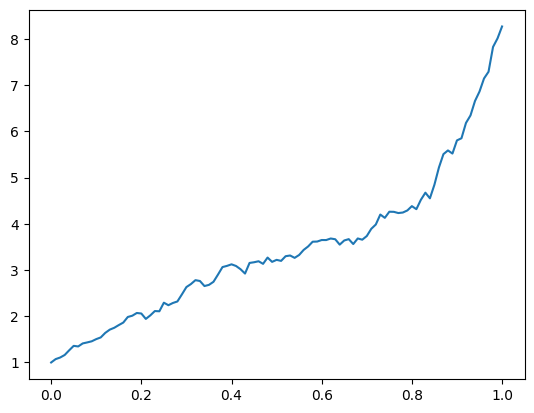

In [ ]:
paths = dataset_mu[0]
plt.plot(np.linspace(0,1,101), paths[0,0])
plt.show()

In [ ]:
seed = 1
test_size = 0.2
train_mu_idx, val_mu_idx = train_test_split(
        np.arange(dataset_mu_metadata["nb_paths"]), test_size=test_size,
        random_state=seed)

data_mu_train = IrregularDataset(dataset_mu, idx=train_mu_idx)
data_mu_val = IrregularDataset(dataset_mu, idx=val_mu_idx)

In [ ]:
_nn = ((50, 'tanh'),)

param_dict_BM = {
    'seed': 2,
    'data_train': data_mu_train,
    'data_val': data_mu_val,
    'dataset_metadata': dataset_mu_metadata,
    'epochs': 100,
    'batch_size': 200,
    'learning_rate': 0.001,
    'hidden_size': 10,
    'bias': True,
    'dropout_rate': 0.1,
    'ode_nn': _nn,
    'readout_nn': None,
    'enc_nn': _nn,
    'dataset_id': None,
    'which_loss': 'easy',
    'use_y_for_ode': True,
    'use_rnn': False,
    'input_sig': False,
    'level': 2,
    'masked': False,
    'evaluate': True,
    'compute_variance': False,
    'func_appl_X': ["power-2"],
}

In [ ]:
model, df_metric, dl, dl_val, dl_test, stockmodel, stockmodel_test = train(**param_dict_BM)

/tmp/ipython-input-10-3732291492.py:217: UserWarning: function application to X and concurrent variance/covariance computation might lead to problems! Use carefully!
  warnings.warn(


using loss: easy
neuralODE use input scaling with tanh
use residual network: input_size=2, output_size=50
use residual network: input_size=50, output_size=2

input_coords: [0]
output_coords: [0]
input_size: 1
output_size: 1
signature_coords: [0]
apply functions to X
new input_coords: [0 1]
new output_coords: [0 1]
no variance computation
optimal (corrected: only original X used) val-loss (achieved by true cond exp): 0.01223
initiate new model ...

model overview:
True
NJODE(
  (ode_f): ODEFunc(
    (f): Sequential(
      (0): Linear(in_features=54, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (encoder_map): FFNN(
    (ffnn): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (readout_map): FFNN(
    (ffnn): Sequential(


40it [00:17,  2.34it/s]

evaluating ...


epoch 1, weight=0.50000, train-loss=3.18766, optimal-val-loss=0.01223, val-loss=2.81449, 
evaluation mean square difference (test set): 0.00140
save new best model: last-best-loss: inf, new-best-loss: 2.81449, epoch: 1
----------------------------------------------------------------------------------------------------


40it [00:17,  2.33it/s]

evaluating ...


epoch 2, weight=0.50000, train-loss=3.01291, optimal-val-loss=0.01223, val-loss=2.62166, 
evaluation mean square difference (test set): 0.00087
save new best model: last-best-loss: 2.81449, new-best-loss: 2.62166, epoch: 2
----------------------------------------------------------------------------------------------------


40it [00:17,  2.33it/s]

evaluating ...


epoch 3, weight=0.50000, train-loss=2.96462, optimal-val-loss=0.01223, val-loss=2.54116, 
evaluation mean square difference (test set): 0.00076
save new best model: last-best-loss: 2.62166, new-best-loss: 2.54116, epoch: 3
----------------------------------------------------------------------------------------------------


40it [00:18,  2.18it/s]

evaluating ...


epoch 4, weight=0.50000, train-loss=2.18612, optimal-val-loss=0.01223, val-loss=2.51652, 
evaluation mean square difference (test set): 0.00059
save new best model: last-best-loss: 2.54116, new-best-loss: 2.51652, epoch: 4
----------------------------------------------------------------------------------------------------


40it [00:17,  2.24it/s]

evaluating ...


epoch 5, weight=0.50000, train-loss=2.61597, optimal-val-loss=0.01223, val-loss=2.50367, 
evaluation mean square difference (test set): 0.00059
save new best model: last-best-loss: 2.51652, new-best-loss: 2.50367, epoch: 5
----------------------------------------------------------------------------------------------------


40it [00:17,  2.24it/s]

evaluating ...


epoch 6, weight=0.50000, train-loss=2.99671, optimal-val-loss=0.01223, val-loss=2.49243, 
evaluation mean square difference (test set): 0.00056
save new best model: last-best-loss: 2.50367, new-best-loss: 2.49243, epoch: 6
----------------------------------------------------------------------------------------------------


40it [00:17,  2.29it/s]

evaluating ...


epoch 7, weight=0.50000, train-loss=2.20296, optimal-val-loss=0.01223, val-loss=2.48370, 
evaluation mean square difference (test set): 0.00055
save new best model: last-best-loss: 2.49243, new-best-loss: 2.48370, epoch: 7
----------------------------------------------------------------------------------------------------


40it [00:17,  2.34it/s]

evaluating ...


epoch 8, weight=0.50000, train-loss=2.65141, optimal-val-loss=0.01223, val-loss=2.45375, 
evaluation mean square difference (test set): 0.00044
save new best model: last-best-loss: 2.48370, new-best-loss: 2.45375, epoch: 8
----------------------------------------------------------------------------------------------------


40it [00:17,  2.34it/s]

evaluating ...


epoch 9, weight=0.50000, train-loss=2.54881, optimal-val-loss=0.01223, val-loss=2.43422, 
evaluation mean square difference (test set): 0.00040
save new best model: last-best-loss: 2.45375, new-best-loss: 2.43422, epoch: 9
----------------------------------------------------------------------------------------------------


40it [00:17,  2.30it/s]

evaluating ...


epoch 10, weight=0.50000, train-loss=2.04832, optimal-val-loss=0.01223, val-loss=2.41280, 
evaluation mean square difference (test set): 0.00031
save new best model: last-best-loss: 2.43422, new-best-loss: 2.41280, epoch: 10
----------------------------------------------------------------------------------------------------


40it [00:17,  2.26it/s]

evaluating ...


epoch 11, weight=0.50000, train-loss=2.56059, optimal-val-loss=0.01223, val-loss=2.37876, 
evaluation mean square difference (test set): 0.00026
save new best model: last-best-loss: 2.41280, new-best-loss: 2.37876, epoch: 11
----------------------------------------------------------------------------------------------------


40it [00:17,  2.29it/s]

evaluating ...


epoch 12, weight=0.50000, train-loss=1.81399, optimal-val-loss=0.01223, val-loss=2.34923, 
evaluation mean square difference (test set): 0.00025
save new best model: last-best-loss: 2.37876, new-best-loss: 2.34923, epoch: 12
----------------------------------------------------------------------------------------------------


40it [00:17,  2.33it/s]

evaluating ...


epoch 13, weight=0.50000, train-loss=2.26777, optimal-val-loss=0.01223, val-loss=2.33212, 
evaluation mean square difference (test set): 0.00037
save new best model: last-best-loss: 2.34923, new-best-loss: 2.33212, epoch: 13
----------------------------------------------------------------------------------------------------


40it [00:16,  2.37it/s]

evaluating ...


epoch 14, weight=0.50000, train-loss=2.08967, optimal-val-loss=0.01223, val-loss=2.30849, 
evaluation mean square difference (test set): 0.00031
save new best model: last-best-loss: 2.33212, new-best-loss: 2.30849, epoch: 14
----------------------------------------------------------------------------------------------------


40it [00:16,  2.35it/s]

evaluating ...


epoch 15, weight=0.50000, train-loss=2.19994, optimal-val-loss=0.01223, val-loss=2.30304, 
evaluation mean square difference (test set): 0.00038
save new best model: last-best-loss: 2.30849, new-best-loss: 2.30304, epoch: 15
----------------------------------------------------------------------------------------------------


40it [00:17,  2.29it/s]

evaluating ...


epoch 16, weight=0.50000, train-loss=2.33860, optimal-val-loss=0.01223, val-loss=2.29270, 
evaluation mean square difference (test set): 0.00033
save new best model: last-best-loss: 2.30304, new-best-loss: 2.29270, epoch: 16
----------------------------------------------------------------------------------------------------


40it [00:17,  2.23it/s]

evaluating ...


epoch 17, weight=0.50000, train-loss=2.38308, optimal-val-loss=0.01223, val-loss=2.28642, 
evaluation mean square difference (test set): 0.00038
save new best model: last-best-loss: 2.29270, new-best-loss: 2.28642, epoch: 17
----------------------------------------------------------------------------------------------------


40it [00:17,  2.30it/s]

evaluating ...


epoch 18, weight=0.50000, train-loss=2.52294, optimal-val-loss=0.01223, val-loss=2.27430, 
evaluation mean square difference (test set): 0.00035
save new best model: last-best-loss: 2.28642, new-best-loss: 2.27430, epoch: 18
----------------------------------------------------------------------------------------------------


40it [00:16,  2.36it/s]

evaluating ...


epoch 19, weight=0.50000, train-loss=2.69572, optimal-val-loss=0.01223, val-loss=2.28785, 
evaluation mean square difference (test set): 0.00029
----------------------------------------------------------------------------------------------------


40it [00:16,  2.35it/s]

evaluating ...


epoch 20, weight=0.50000, train-loss=2.63108, optimal-val-loss=0.01223, val-loss=2.27228, 
evaluation mean square difference (test set): 0.00029
save new best model: last-best-loss: 2.27430, new-best-loss: 2.27228, epoch: 20
----------------------------------------------------------------------------------------------------


40it [00:17,  2.33it/s]

evaluating ...


epoch 21, weight=0.50000, train-loss=2.05793, optimal-val-loss=0.01223, val-loss=2.26868, 
evaluation mean square difference (test set): 0.00028
save new best model: last-best-loss: 2.27228, new-best-loss: 2.26868, epoch: 21
----------------------------------------------------------------------------------------------------


40it [00:17,  2.26it/s]

evaluating ...


epoch 22, weight=0.50000, train-loss=1.92312, optimal-val-loss=0.01223, val-loss=2.26079, 
evaluation mean square difference (test set): 0.00026
save new best model: last-best-loss: 2.26868, new-best-loss: 2.26079, epoch: 22
----------------------------------------------------------------------------------------------------


40it [00:17,  2.23it/s]

evaluating ...


epoch 23, weight=0.50000, train-loss=2.17575, optimal-val-loss=0.01223, val-loss=2.27296, 
evaluation mean square difference (test set): 0.00026
----------------------------------------------------------------------------------------------------


40it [00:17,  2.33it/s]

evaluating ...


epoch 24, weight=0.50000, train-loss=1.99165, optimal-val-loss=0.01223, val-loss=2.25949, 
evaluation mean square difference (test set): 0.00024
save new best model: last-best-loss: 2.26079, new-best-loss: 2.25949, epoch: 24
----------------------------------------------------------------------------------------------------


40it [00:16,  2.37it/s]

evaluating ...


epoch 25, weight=0.50000, train-loss=2.38715, optimal-val-loss=0.01223, val-loss=2.26167, 
evaluation mean square difference (test set): 0.00026
----------------------------------------------------------------------------------------------------


40it [00:17,  2.35it/s]

evaluating ...


epoch 26, weight=0.50000, train-loss=2.26884, optimal-val-loss=0.01223, val-loss=2.26245, 
evaluation mean square difference (test set): 0.00024
----------------------------------------------------------------------------------------------------


40it [00:16,  2.37it/s]

evaluating ...


epoch 27, weight=0.50000, train-loss=2.39259, optimal-val-loss=0.01223, val-loss=2.26810, 
evaluation mean square difference (test set): 0.00024
----------------------------------------------------------------------------------------------------


40it [00:17,  2.25it/s]

evaluating ...


epoch 28, weight=0.50000, train-loss=2.64250, optimal-val-loss=0.01223, val-loss=2.25865, 
evaluation mean square difference (test set): 0.00025
save new best model: last-best-loss: 2.25949, new-best-loss: 2.25865, epoch: 28
----------------------------------------------------------------------------------------------------


40it [00:17,  2.26it/s]

evaluating ...


epoch 29, weight=0.50000, train-loss=1.96697, optimal-val-loss=0.01223, val-loss=2.25601, 
evaluation mean square difference (test set): 0.00023
save new best model: last-best-loss: 2.25865, new-best-loss: 2.25601, epoch: 29
----------------------------------------------------------------------------------------------------


40it [00:16,  2.36it/s]

evaluating ...


epoch 30, weight=0.50000, train-loss=2.04053, optimal-val-loss=0.01223, val-loss=2.25406, 
evaluation mean square difference (test set): 0.00023
save new best model: last-best-loss: 2.25601, new-best-loss: 2.25406, epoch: 30
----------------------------------------------------------------------------------------------------


40it [00:16,  2.36it/s]

evaluating ...


epoch 31, weight=0.50000, train-loss=2.85043, optimal-val-loss=0.01223, val-loss=2.25113, 
evaluation mean square difference (test set): 0.00022
save new best model: last-best-loss: 2.25406, new-best-loss: 2.25113, epoch: 31
----------------------------------------------------------------------------------------------------


40it [00:16,  2.35it/s]

evaluating ...


epoch 32, weight=0.50000, train-loss=2.31057, optimal-val-loss=0.01223, val-loss=2.25998, 
evaluation mean square difference (test set): 0.00022
----------------------------------------------------------------------------------------------------


40it [00:17,  2.29it/s]

evaluating ...


epoch 33, weight=0.50000, train-loss=1.99532, optimal-val-loss=0.01223, val-loss=2.25235, 
evaluation mean square difference (test set): 0.00022
----------------------------------------------------------------------------------------------------


40it [00:17,  2.25it/s]

evaluating ...


epoch 34, weight=0.50000, train-loss=1.85746, optimal-val-loss=0.01223, val-loss=2.24754, 
evaluation mean square difference (test set): 0.00022
save new best model: last-best-loss: 2.25113, new-best-loss: 2.24754, epoch: 34
----------------------------------------------------------------------------------------------------


40it [00:17,  2.32it/s]

evaluating ...


epoch 35, weight=0.50000, train-loss=2.39993, optimal-val-loss=0.01223, val-loss=2.25188, 
evaluation mean square difference (test set): 0.00022
----------------------------------------------------------------------------------------------------


40it [00:16,  2.36it/s]

evaluating ...


epoch 36, weight=0.50000, train-loss=1.74577, optimal-val-loss=0.01223, val-loss=2.24930, 
evaluation mean square difference (test set): 0.00022
----------------------------------------------------------------------------------------------------


40it [00:16,  2.37it/s]

evaluating ...


epoch 37, weight=0.50000, train-loss=2.50132, optimal-val-loss=0.01223, val-loss=2.24685, 
evaluation mean square difference (test set): 0.00023
save new best model: last-best-loss: 2.24754, new-best-loss: 2.24685, epoch: 37
----------------------------------------------------------------------------------------------------


40it [00:16,  2.35it/s]

evaluating ...


epoch 38, weight=0.50000, train-loss=2.11457, optimal-val-loss=0.01223, val-loss=2.24691, 
evaluation mean square difference (test set): 0.00022
----------------------------------------------------------------------------------------------------


40it [00:17,  2.25it/s]

evaluating ...


epoch 39, weight=0.50000, train-loss=2.23664, optimal-val-loss=0.01223, val-loss=2.24394, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.24685, new-best-loss: 2.24394, epoch: 39
----------------------------------------------------------------------------------------------------


40it [00:17,  2.25it/s]

evaluating ...


epoch 40, weight=0.50000, train-loss=2.18994, optimal-val-loss=0.01223, val-loss=2.24576, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:17,  2.26it/s]

evaluating ...


epoch 41, weight=0.50000, train-loss=2.52591, optimal-val-loss=0.01223, val-loss=2.25019, 
evaluation mean square difference (test set): 0.00023
----------------------------------------------------------------------------------------------------


40it [00:17,  2.29it/s]

evaluating ...


epoch 42, weight=0.50000, train-loss=2.44059, optimal-val-loss=0.01223, val-loss=2.25037, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:17,  2.29it/s]

evaluating ...


epoch 43, weight=0.50000, train-loss=1.94281, optimal-val-loss=0.01223, val-loss=2.24508, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:17,  2.25it/s]

evaluating ...


epoch 44, weight=0.50000, train-loss=2.32146, optimal-val-loss=0.01223, val-loss=2.24431, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:17,  2.23it/s]

evaluating ...


epoch 45, weight=0.50000, train-loss=2.13828, optimal-val-loss=0.01223, val-loss=2.24218, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.24394, new-best-loss: 2.24218, epoch: 45
----------------------------------------------------------------------------------------------------


40it [00:18,  2.20it/s]

evaluating ...


epoch 46, weight=0.50000, train-loss=2.49823, optimal-val-loss=0.01223, val-loss=2.25131, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:18,  2.17it/s]

evaluating ...


epoch 47, weight=0.50000, train-loss=2.52825, optimal-val-loss=0.01223, val-loss=2.23771, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.24218, new-best-loss: 2.23771, epoch: 47
----------------------------------------------------------------------------------------------------


40it [00:19,  2.10it/s]

evaluating ...


epoch 48, weight=0.50000, train-loss=2.33232, optimal-val-loss=0.01223, val-loss=2.24159, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:18,  2.13it/s]

evaluating ...


epoch 49, weight=0.50000, train-loss=1.99500, optimal-val-loss=0.01223, val-loss=2.24289, 
evaluation mean square difference (test set): 0.00023
----------------------------------------------------------------------------------------------------


40it [00:18,  2.17it/s]

evaluating ...


epoch 50, weight=0.50000, train-loss=2.10965, optimal-val-loss=0.01223, val-loss=2.23979, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:18,  2.22it/s]

evaluating ...


epoch 51, weight=0.50000, train-loss=2.69988, optimal-val-loss=0.01223, val-loss=2.23933, 
evaluation mean square difference (test set): 0.00023
----------------------------------------------------------------------------------------------------


40it [00:17,  2.22it/s]

evaluating ...


epoch 52, weight=0.50000, train-loss=2.57952, optimal-val-loss=0.01223, val-loss=2.24138, 
evaluation mean square difference (test set): 0.00022
----------------------------------------------------------------------------------------------------


40it [00:17,  2.25it/s]

evaluating ...


epoch 53, weight=0.50000, train-loss=2.24984, optimal-val-loss=0.01223, val-loss=2.23622, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.23771, new-best-loss: 2.23622, epoch: 53
----------------------------------------------------------------------------------------------------


40it [00:17,  2.23it/s]

evaluating ...


epoch 54, weight=0.50000, train-loss=2.40507, optimal-val-loss=0.01223, val-loss=2.23460, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.23622, new-best-loss: 2.23460, epoch: 54
----------------------------------------------------------------------------------------------------


40it [00:18,  2.21it/s]

evaluating ...


epoch 55, weight=0.50000, train-loss=2.41469, optimal-val-loss=0.01223, val-loss=2.23395, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.23460, new-best-loss: 2.23395, epoch: 55
----------------------------------------------------------------------------------------------------


40it [00:18,  2.19it/s]

evaluating ...


epoch 56, weight=0.50000, train-loss=2.24593, optimal-val-loss=0.01223, val-loss=2.23782, 
evaluation mean square difference (test set): 0.00024
----------------------------------------------------------------------------------------------------


40it [00:18,  2.16it/s]

evaluating ...


epoch 57, weight=0.50000, train-loss=2.57427, optimal-val-loss=0.01223, val-loss=2.23871, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:18,  2.13it/s]

evaluating ...


epoch 58, weight=0.50000, train-loss=2.27959, optimal-val-loss=0.01223, val-loss=2.23484, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.08it/s]

evaluating ...


epoch 59, weight=0.50000, train-loss=1.78413, optimal-val-loss=0.01223, val-loss=2.23246, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.23395, new-best-loss: 2.23246, epoch: 59
----------------------------------------------------------------------------------------------------


40it [00:19,  2.07it/s]

evaluating ...


epoch 60, weight=0.50000, train-loss=2.16422, optimal-val-loss=0.01223, val-loss=2.23451, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 61, weight=0.50000, train-loss=1.99048, optimal-val-loss=0.01223, val-loss=2.23424, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 62, weight=0.50000, train-loss=2.48398, optimal-val-loss=0.01223, val-loss=2.23152, 
evaluation mean square difference (test set): 0.00022
save new best model: last-best-loss: 2.23246, new-best-loss: 2.23152, epoch: 62
----------------------------------------------------------------------------------------------------


40it [00:19,  2.08it/s]

evaluating ...


epoch 63, weight=0.50000, train-loss=2.54677, optimal-val-loss=0.01223, val-loss=2.23129, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.23152, new-best-loss: 2.23129, epoch: 63
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 64, weight=0.50000, train-loss=2.17273, optimal-val-loss=0.01223, val-loss=2.23193, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:20,  1.98it/s]

evaluating ...


epoch 65, weight=0.50000, train-loss=2.24015, optimal-val-loss=0.01223, val-loss=2.23049, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.23129, new-best-loss: 2.23049, epoch: 65
----------------------------------------------------------------------------------------------------


40it [00:19,  2.06it/s]

evaluating ...


epoch 66, weight=0.50000, train-loss=3.07821, optimal-val-loss=0.01223, val-loss=2.23314, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 67, weight=0.50000, train-loss=2.23748, optimal-val-loss=0.01223, val-loss=2.22997, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.23049, new-best-loss: 2.22997, epoch: 67
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 68, weight=0.50000, train-loss=2.52299, optimal-val-loss=0.01223, val-loss=2.22861, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.22997, new-best-loss: 2.22861, epoch: 68
----------------------------------------------------------------------------------------------------


40it [00:19,  2.03it/s]

evaluating ...


epoch 69, weight=0.50000, train-loss=2.30366, optimal-val-loss=0.01223, val-loss=2.22764, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.22861, new-best-loss: 2.22764, epoch: 69
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 70, weight=0.50000, train-loss=2.17790, optimal-val-loss=0.01223, val-loss=2.22968, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 71, weight=0.50000, train-loss=2.10431, optimal-val-loss=0.01223, val-loss=2.22885, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 72, weight=0.50000, train-loss=2.30540, optimal-val-loss=0.01223, val-loss=2.22957, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 73, weight=0.50000, train-loss=2.44204, optimal-val-loss=0.01223, val-loss=2.23154, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:19,  2.01it/s]

evaluating ...


epoch 74, weight=0.50000, train-loss=2.77790, optimal-val-loss=0.01223, val-loss=2.22626, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22764, new-best-loss: 2.22626, epoch: 74
----------------------------------------------------------------------------------------------------


40it [00:19,  2.03it/s]

evaluating ...


epoch 75, weight=0.50000, train-loss=2.25604, optimal-val-loss=0.01223, val-loss=2.23191, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.06it/s]

evaluating ...


epoch 76, weight=0.50000, train-loss=2.47441, optimal-val-loss=0.01223, val-loss=2.23001, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 77, weight=0.50000, train-loss=2.20458, optimal-val-loss=0.01223, val-loss=2.22600, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22626, new-best-loss: 2.22600, epoch: 77
----------------------------------------------------------------------------------------------------


40it [00:19,  2.01it/s]

evaluating ...


epoch 78, weight=0.50000, train-loss=2.27266, optimal-val-loss=0.01223, val-loss=2.22531, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22600, new-best-loss: 2.22531, epoch: 78
----------------------------------------------------------------------------------------------------


40it [00:19,  2.01it/s]

evaluating ...


epoch 79, weight=0.50000, train-loss=2.09481, optimal-val-loss=0.01223, val-loss=2.22554, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 80, weight=0.50000, train-loss=2.25246, optimal-val-loss=0.01223, val-loss=2.22458, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22531, new-best-loss: 2.22458, epoch: 80
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 81, weight=0.50000, train-loss=2.03171, optimal-val-loss=0.01223, val-loss=2.22408, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.22458, new-best-loss: 2.22408, epoch: 81
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 82, weight=0.50000, train-loss=2.49895, optimal-val-loss=0.01223, val-loss=2.22449, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 83, weight=0.50000, train-loss=2.32647, optimal-val-loss=0.01223, val-loss=2.22369, 
evaluation mean square difference (test set): 0.00021
save new best model: last-best-loss: 2.22408, new-best-loss: 2.22369, epoch: 83
----------------------------------------------------------------------------------------------------


40it [00:19,  2.02it/s]

evaluating ...


epoch 84, weight=0.50000, train-loss=2.42837, optimal-val-loss=0.01223, val-loss=2.22232, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22369, new-best-loss: 2.22232, epoch: 84
----------------------------------------------------------------------------------------------------


40it [00:19,  2.06it/s]

evaluating ...


epoch 85, weight=0.50000, train-loss=2.21410, optimal-val-loss=0.01223, val-loss=2.22480, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 86, weight=0.50000, train-loss=2.04375, optimal-val-loss=0.01223, val-loss=2.22382, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 87, weight=0.50000, train-loss=2.08787, optimal-val-loss=0.01223, val-loss=2.22225, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22232, new-best-loss: 2.22225, epoch: 87
----------------------------------------------------------------------------------------------------


40it [00:23,  1.69it/s]

evaluating ...


epoch 88, weight=0.50000, train-loss=2.65039, optimal-val-loss=0.01223, val-loss=2.22351, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.02it/s]

evaluating ...


epoch 89, weight=0.50000, train-loss=2.09760, optimal-val-loss=0.01223, val-loss=2.22280, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 90, weight=0.50000, train-loss=2.04636, optimal-val-loss=0.01223, val-loss=2.22467, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.02it/s]

evaluating ...


epoch 91, weight=0.50000, train-loss=1.96399, optimal-val-loss=0.01223, val-loss=2.22330, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 92, weight=0.50000, train-loss=2.35488, optimal-val-loss=0.01223, val-loss=2.22071, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22225, new-best-loss: 2.22071, epoch: 92
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 93, weight=0.50000, train-loss=2.31324, optimal-val-loss=0.01223, val-loss=2.22091, 
evaluation mean square difference (test set): 0.00021
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 94, weight=0.50000, train-loss=2.28054, optimal-val-loss=0.01223, val-loss=2.22063, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22071, new-best-loss: 2.22063, epoch: 94
----------------------------------------------------------------------------------------------------


40it [00:19,  2.06it/s]

evaluating ...


epoch 95, weight=0.50000, train-loss=2.08165, optimal-val-loss=0.01223, val-loss=2.21970, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.22063, new-best-loss: 2.21970, epoch: 95
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 96, weight=0.50000, train-loss=2.40488, optimal-val-loss=0.01223, val-loss=2.21864, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.21970, new-best-loss: 2.21864, epoch: 96
----------------------------------------------------------------------------------------------------


40it [00:19,  2.05it/s]

evaluating ...


epoch 97, weight=0.50000, train-loss=2.36030, optimal-val-loss=0.01223, val-loss=2.22016, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.04it/s]

evaluating ...


epoch 98, weight=0.50000, train-loss=2.32637, optimal-val-loss=0.01223, val-loss=2.21900, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


40it [00:19,  2.03it/s]

evaluating ...


epoch 99, weight=0.50000, train-loss=2.28965, optimal-val-loss=0.01223, val-loss=2.21791, 
evaluation mean square difference (test set): 0.00020
save new best model: last-best-loss: 2.21864, new-best-loss: 2.21791, epoch: 99
----------------------------------------------------------------------------------------------------


40it [00:19,  2.08it/s]

evaluating ...


epoch 100, weight=0.50000, train-loss=1.96164, optimal-val-loss=0.01223, val-loss=2.21879, 
evaluation mean square difference (test set): 0.00020
----------------------------------------------------------------------------------------------------


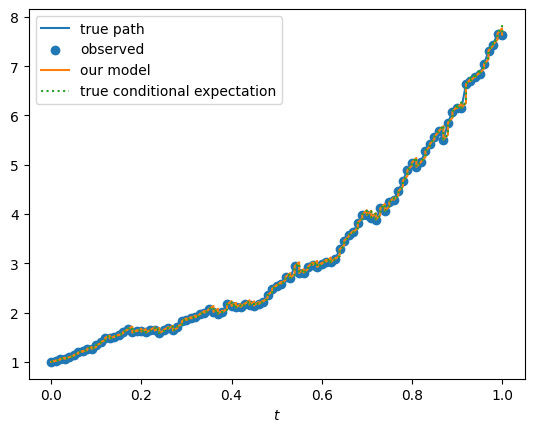

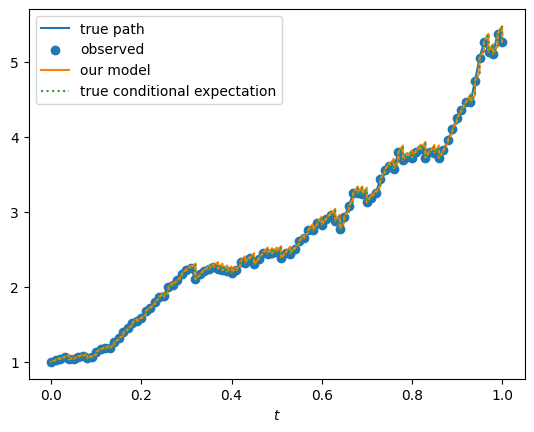

optimal loss (test): 0.012233841426095819
model loss   (test): 2.412797451019287


In [ ]:
batch = next(iter(dl_test))

opt_loss, current_model_loss = plot_one_path_with_pred(
    device=None, model=model, batch=batch, stockmodel=stockmodel_test,
    delta_t=dataset_mu_metadata["dt"], T=dataset_mu_metadata["maturity"],
    path_to_plot=(0,1), reuse_cond_exp=False,)
print('optimal loss (test): {}'.format(opt_loss))
print('model loss   (test): {}'.format(current_model_loss))

# Generate new paths

In [ ]:
def generate_next_value( X_t, mu_t, sigma_t, delta_t):
   """
   Generate the next value in the time series using the Euler-Maruyama scheme.

   :param X_t: current value tensor of shape (batch_size, d)
   :param mu_t: drift coefficient tensor of shape (batch_size, d)
   :param sigma_t: diffusion coefficient tensor of shape ( d, d)
   :param delta_t: time difference float
   :return: next value tensor of shape (batch_size, d)
   """
   delta_Wt = torch.randn_like(X_t) * np.sqrt(delta_t)
   delta_Wt_sigma_t = delta_Wt * sigma_t
   X_t_next = X_t + mu_t * delta_t + delta_Wt_sigma_t
   return X_t_next



In [ ]:
batch_size=1
dim=1
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
Z = torch.tensor([], dtype=torch.float)
delta_t=0.01
X= torch.tensor([], dtype=torch.float)
start_X = torch.tensor([1.0, 1.0**2], dtype=torch.float).unsqueeze(0)
start_X = start_X.repeat(batch_size, dim)
n_obs_ot=torch.tensor([0]*batch_size, dtype=torch.float)
count=0

T=0.01
pred1=model.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]
mu_hat = (pred1[:,0] - start_X[:,0])/delta_t
sigma_hat =  (pred1[:,1] - start_X[:,0]**2)/delta_t - 2*start_X[:,0]*mu_hat

In [ ]:
mu_hat

tensor([2.6189], grad_fn=<DivBackward0>)

In [ ]:
sigma_hat

tensor([17.9515], grad_fn=<SubBackward0>)

In [ ]:
batch_size=10
dim=1
times=np.array([])
time_ptr = np.array([0])
obs_idx = torch.tensor([],dtype=torch.long)
delta_t=0.01
X= torch.tensor([], dtype=torch.float)
start_X_value = 1.0
start_X = torch.tensor([[start_X_value, start_X_value**2]], dtype=torch.float).repeat(batch_size, 1)
n_obs_ot=torch.tensor([0]*batch_size, dtype=torch.float)
count=0
for i in range(1, 101):

    T=delta_t*i

    pred=model.get_pred(times, time_ptr, X, obs_idx, delta_t, T, start_X, n_obs_ot)["pred"][-1]

    if i==1:
        X_t=start_X
    else:
        X_t = X_next


    mu_hat_t = (pred[:,0] - X_t[:,0])/delta_t
    sigma_hat_t =  (pred[:,1] - X_t[:,0]*X_t[:,0])/delta_t - 2*X_t[:,0]*mu_hat_t


    vol = torch.sqrt(sigma_hat_t)

    X_next = generate_next_value(X_t[:,0].unsqueeze(1), mu_hat_t.unsqueeze(1), vol.unsqueeze(1), delta_t)
    X_next = torch.cat((X_next, X_next**2), dim=1)


    X=torch.cat((X, X_next), dim=0)
    times=np.append(times, delta_t*i)
    time_ptr = np.append(time_ptr, i*batch_size)
    obs_idx=torch.cat((obs_idx, torch.arange(batch_size)))
    n_obs_ot+=torch.tensor([1]*batch_size, dtype=torch.float)
X_new1 = X.view(100, batch_size, 2).permute(1, 2, 0)
start_X_expanded1 = start_X.unsqueeze(2)
X_final1=torch.cat((start_X_expanded1, X_new1), dim=2)

## Parameter estimates and Graphs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Compare (visualize) paths
def compare_path(x_real, x_fake, titles=["Real", "Fake"], file_path=None, return_figax=False, dim=0, plot_size=100):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4], sharex=True, sharey=True)
    ax[0].plot(
        x_real[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )

    ax[1].plot(
        x_fake[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )

    if titles:
        ax[0].set_title(titles[0])
        ax[1].set_title(titles[1])

    for i in range(2):
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Prices")
    if return_figax:
        return fig, ax
    if file_path is None:
        plt.show()
    else:
        fig.savefig(os.path.join(file_path, 'bs_term.png'))
    plt.close()

In [ ]:
def estimate_params(X, dt=0.01):
  rets = np.log(X[:,1:]/X[:,:-1])
  #rets=X[:,1:]/X[:,:-1]-1
  r=rets.ravel()

  m=np.mean(r)
  s=np.std(r)

  sigma=s/np.sqrt(dt)
  mu=m/dt+0.5*sigma**2
  return mu, sigma
  #return m, s

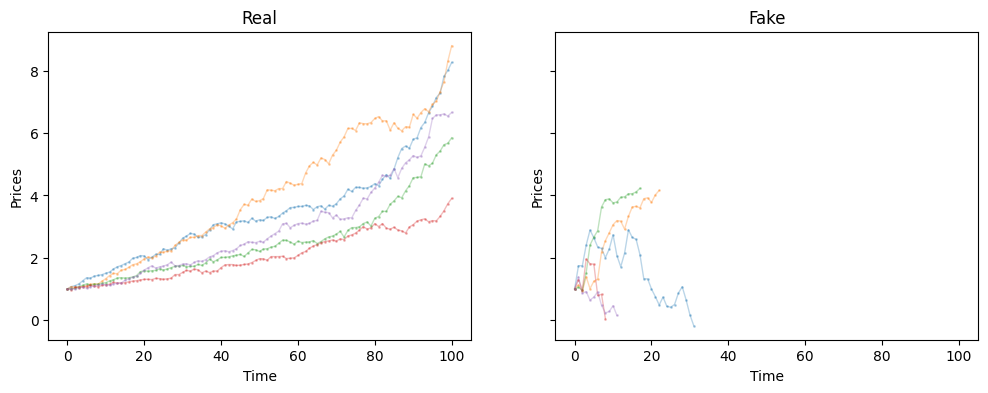

In [ ]:
compare_path(torch.tensor(dataset_mu[0][:,0,:]),X_final1[:,0,:].detach(),plot_size=5)

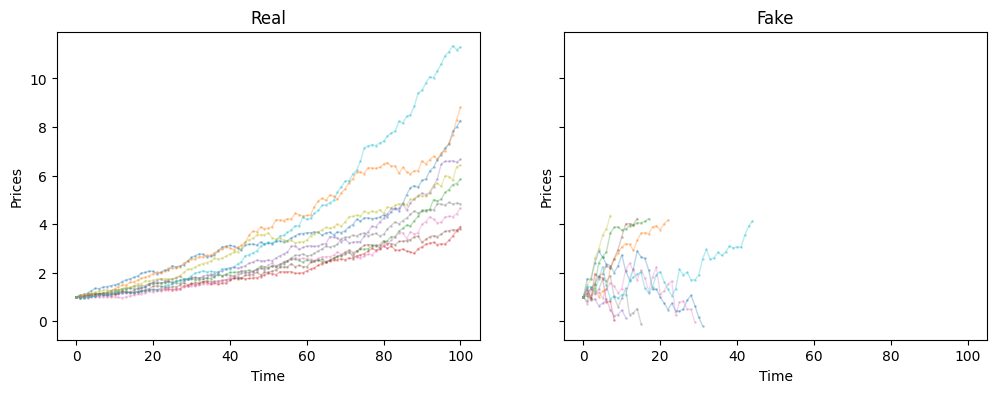

In [ ]:
compare_path(torch.tensor(dataset_mu[0][:,0,:]),X_final1[:,0,:].detach(),plot_size=10)